# Vessel Data available from marinetraffic.com

In this notebook the sanitized vessel track data from marinetraffic.com is visualy inspected. Data is located in `data/marine-traffic/sanitized` in the form of csv data files

In [139]:
# load dependecies
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from glob import glob
from os import path
from mpl_toolkits.basemap import Basemap
from config import VESSEL_NAMES
from plot_mtdata import plot_track

from collections import defaultdict

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# make plots interactive
%matplotlib notebook

%reload_ext autoreload
%autoreload 2


In [140]:
vessels = dict()
for vessel_file in glob(path.join('../../data/marine-traffic/sanitized/*.csv')):
    print(f'processing file {vessel_file}')
    vessel = vessel_file.split('/')[-1].split('.')[0]
    vessels[vessel] = pd.read_csv(vessel_file)
    vessels[vessel].epoch = pd.to_datetime(vessels[vessel].epoch, utc=True)
    vessels[vessel].set_index('epoch', inplace = True)
    
    if vessels[vessel].index.has_duplicates:
        vessels[vessel] = vessels[vessel][~vessels[vessel].index.duplicated(keep='first')]
    print(f'before resampling: len(vessels[vessel]) = {len(vessels[vessel])}')
    vessels[vessel] = vessels[vessel].resample('1h').pad()
    print(f'before dropping NaNs: len(vessels[vessel]) = {len(vessels[vessel])}')
    vessels[vessel].dropna(inplace=True)
    print(f'after dropping NaNs: len(vessels[vessel]) = {len(vessels[vessel])}')
    vessels[vessel].drop_duplicates(inplace=True, ignore_index=False)
    print(f'after dropping duplicate rows: len(vessels[vessel]) = {len(vessels[vessel])}')

processing file ../../data/marine-traffic/sanitized/235090598_blue-tern.csv
before resampling: len(vessels[vessel]) = 42261
before dropping NaNs: len(vessels[vessel]) = 47430
after dropping NaNs: len(vessels[vessel]) = 47429
after dropping duplicate rows: len(vessels[vessel]) = 42219
processing file ../../data/marine-traffic/sanitized/245924000_mpi-adventure.csv
before resampling: len(vessels[vessel]) = 87082
before dropping NaNs: len(vessels[vessel]) = 104142
after dropping NaNs: len(vessels[vessel]) = 104141
after dropping duplicate rows: len(vessels[vessel]) = 84761
processing file ../../data/marine-traffic/sanitized/219019002_sea-challenger.csv
before resampling: len(vessels[vessel]) = 59129
before dropping NaNs: len(vessels[vessel]) = 69265
after dropping NaNs: len(vessels[vessel]) = 69263
after dropping duplicate rows: len(vessels[vessel]) = 58649
processing file ../../data/marine-traffic/sanitized/253609000_taillevent.csv
before resampling: len(vessels[vessel]) = 8
before droppi

In [141]:
vessels[vessel]

latitude   longitude  speed  heading  course  \
epoch                                                                     
2010-03-18 17:00:00+00:00  35.20683  139.724300    0.0    270.0   270.0   
2010-03-18 19:00:00+00:00  35.20683  139.724300    0.0    270.0   270.0   
2010-03-19 00:00:00+00:00  35.20683  139.724300    0.0    270.0   270.0   
2010-03-19 05:00:00+00:00  35.20683  139.724300    0.0    270.0   270.0   
2010-03-19 10:00:00+00:00  35.20683  139.724300    0.0    270.0   270.0   
...                             ...         ...    ...      ...     ...   
2021-11-18 12:00:00+00:00  53.86305    8.714467    0.0    292.0   209.0   
2021-11-18 13:00:00+00:00  53.86309    8.714510    0.0    292.0   209.0   
2021-11-18 14:00:00+00:00  53.86308    8.714527    0.0    292.0   209.0   
2021-11-18 15:00:00+00:00  53.86305    8.714507    0.0    292.0   209.0   
2021-11-18 16:00:00+00:00  53.86307    8.714507    0.0    292.0   209.0   

                           status     timestamp  
epoch                                            
2010-03-18 17:00:00+00:00    15.0  1.268929e+09  
2010-03-18 19:00:00+00:00    15.0  1.268938e+09  
2010-03-19 00:00:00+00:00    15.0  1.268956e+09  
2010-03-19 05:00:00+00:00    15.0  1.268973e+09  
2010-03-19 10:00:00+00:00    15.0  1.268991e+09  
...                           ...           ...  
2021-11-18 12:00:00+00:00     6.0  1.637234e+09  
2021-11-18 13:00:00+00:00     6.0  1.637238e+09  
2021-11-18 14:00:00+00:00     6.0  1.637241e+09  
2021-11-18 15:00:00+00:00     6.0  1.637245e+09  
2021-11-18 16:00:00+00:00     6.0  1.637248e+09  

[70580 rows x 7 columns]

In [142]:
wind_farms = pd.read_csv('../../data/wind-farms/wind-farms.txt')
wind_farms.insert(loc=0, column='key_name', value=wind_farms.windfarm_name.apply(lambda x: x.lower().replace('&', '_').replace(' ', '_').replace('/', '_')))
wind_farms.set_index('key_name', inplace=True)
wind_farms.construction_begin = pd.to_datetime(wind_farms.construction_begin, utc=True)
wind_farms.construction_end = pd.to_datetime(wind_farms.construction_end, utc=True)

In [219]:
search_window_size = 0.3 # deg lon/lat e.g. 11 km
vessel_farms = defaultdict(dict)

for vessel, data in vessels.items():
    print(f'processing {vessel}')
    for farm_index, farm in wind_farms.iterrows():
        num_data_points = 0
        try:
            num_data_points = len(data[farm.construction_begin:farm.construction_end])
        except Exception as e:
            print(f'failed to index vessel data: {e}')
            continue
            
        if num_data_points > 0:
            print(f'    found vessel data for wind farm {farm.windfarm_name} construction period: {farm.construction_begin} -> {farm.construction_end}')
            
            # construct search window
            lat_min = farm.latitude - search_window_size
            lat_max = farm.latitude + search_window_size            
            lon_min = farm.longitude - search_window_size
            lon_max = farm.longitude + search_window_size

            
            d = vessels[vessel][farm.construction_begin:farm.construction_end][
                (vessels[vessel][farm.construction_begin:farm.construction_end].latitude > lat_min) &
                (vessels[vessel][farm.construction_begin:farm.construction_end].latitude < lat_max) &
                (vessels[vessel][farm.construction_begin:farm.construction_end].longitude > lon_min) &
                (vessels[vessel][farm.construction_begin:farm.construction_end].longitude < lon_max) &
                (vessels[vessel][farm.construction_begin:farm.construction_end].speed == 0)
            ]
            
            if len(d) > 100:
                print(f'        found {len(d)} vessel positions in search windows for wind farm {farm.windfarm_name}')
                vessel_farms[vessel][farm_index] = d


processing 235090598_blue-tern
    found vessel data for wind farm Norther Offshore Wind Farm construction period: 2018-08-01 00:00:00+00:00 -> 2019-08-01 00:00:00+00:00
    found vessel data for wind farm Hohe See construction period: 2018-04-01 00:00:00+00:00 -> 2021-08-01 00:00:00+00:00
        found 1579 vessel positions in search windows for wind farm Hohe See
    found vessel data for wind farm Veja Mate construction period: 2016-04-01 00:00:00+00:00 -> 2017-05-01 00:00:00+00:00
    found vessel data for wind farm Merkur construction period: 2017-04-01 00:00:00+00:00 -> 2018-09-01 00:00:00+00:00
        found 2287 vessel positions in search windows for wind farm Merkur
    found vessel data for wind farm Arkona construction period: 2017-08-01 00:00:00+00:00 -> 2018-02-01 00:00:00+00:00
    found vessel data for wind farm Wikinger construction period: 2016-02-01 00:00:00+00:00 -> 2017-10-01 00:00:00+00:00
    found vessel data for wind farm Nordsee One construction period: 2015-12

    found vessel data for wind farm Butendiek construction period: 2014-06-01 00:00:00+00:00 -> 2015-06-11 00:00:00+00:00
    found vessel data for wind farm Dan Tysk construction period: 2013-02-01 00:00:00+00:00 -> 2014-08-01 00:00:00+00:00
    found vessel data for wind farm Baltic 2 construction period: 2013-08-01 00:00:00+00:00 -> 2015-04-01 00:00:00+00:00
    found vessel data for wind farm Meerwind Sued/Ost construction period: 2012-08-01 00:00:00+00:00 -> 2014-09-01 00:00:00+00:00
    found vessel data for wind farm Sandbank construction period: 2015-04-01 00:00:00+00:00 -> 2017-01-21 00:00:00+00:00
    found vessel data for wind farm Gode Wind 2 construction period: 2015-04-01 00:00:00+00:00 -> 2017-06-01 00:00:00+00:00
    found vessel data for wind farm Deutsche Bucht construction period: 2017-07-01 00:00:00+00:00 -> 2019-06-01 00:00:00+00:00
    found vessel data for wind farm Trianel Borkum West 2 construction period: 2011-08-01 00:00:00+00:00 -> 2014-06-01 00:00:00+00:00


        found 1132 vessel positions in search windows for wind farm Borssele 3&4
    found vessel data for wind farm Gemini Wind Farm construction period: 2015-07-01 00:00:00+00:00 -> 2016-10-01 00:00:00+00:00
        found 125 vessel positions in search windows for wind farm Gemini Wind Farm
    found vessel data for wind farm Hornesea 1 construction period: 2017-01-01 00:00:00+00:00 -> 2019-10-01 00:00:00+00:00
        found 590 vessel positions in search windows for wind farm Hornesea 1
    found vessel data for wind farm Gwynty Mor construction period: 2013-04-01 00:00:00+00:00 -> 2014-07-01 00:00:00+00:00
    found vessel data for wind farm Race Bank construction period: 2017-05-01 00:00:00+00:00 -> 2018-02-01 00:00:00+00:00
    found vessel data for wind farm Dudgeon construction period: 2017-01-01 00:00:00+00:00 -> 2017-10-01 00:00:00+00:00
    found vessel data for wind farm Rampion construction period: 2017-03-10 00:00:00+00:00 -> 2017-10-01 00:00:00+00:00
    found vessel dat

In [222]:
def draw_screen_poly( lats, lons, m):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( list(xy), facecolor='red', zorder=5 )
    plt.gca().add_patch(poly)

def plot_vessel_farms(vessel : pd.DataFrame, vessel_farms : dict, wind_farms : pd.DataFrame, search_window_size=0.3, figsize=(16,9), margin=0.2):
    # create new figure, axes instances.
    fig = plt.figure(figsize=figsize)
    
    # to create the figure, we need the complete minima and maxima of the vessel coordinates
    
    min_lat = 0
    max_lat = 0
    min_lon = 0
    max_lon = 0

    for i, (farm_key, data) in enumerate(vessel_farms.items()):
        # find local min and max:
        # if we are at the first wind farm, just store the local min and max
        if i == 0:
            min_lat = data.latitude.min() - margin
            max_lat = data.latitude.max() + margin
            min_lon = data.longitude.min() - margin
            max_lon = data.longitude.max() + margin
            
        else: 

            local_min_lat = data.latitude.min() - margin
            local_max_lat = data.latitude.max() + margin
            local_min_lon = data.longitude.min() - margin
            local_max_lon = data.longitude.max() + margin

            if local_min_lat < min_lat:
                min_lat = local_min_lat
            if local_max_lat > max_lat:
                max_lat = local_max_lat
            if local_min_lon < min_lon:
                min_lon = local_min_lon
            if local_max_lon > max_lon:
                max_lon = local_max_lon
    
    print(min_lat, max_lat, min_lon, max_lon)
        
    

    m = Basemap(llcrnrlon=min_lon,
                llcrnrlat=min_lat,
                urcrnrlon=max_lon,
                urcrnrlat=max_lat,
                resolution='h',
                projection='merc',
                lat_0=(max_lat - min_lat)/2,
                lon_0=(max_lon - min_lon)/2,
               )

    m.drawcoastlines()
    m.fillcontinents()
    # m.drawcountries()
    m.drawstates()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color = 'white',lake_color='#46bcec')
    # draw parallels
    m.drawparallels(np.arange(-90,90,2),labels=[1,1,1,1])
    # draw meridians
    m.drawmeridians(np.arange(-180,180,2),labels=[1,1,1,1])
    
    ## iterate over the selected wind farms again and add them to the map
    for farm_key, data in vessel_farms.items():
        # draw the wind farm center and a rectangular region around it
        farm_lon, farm_lat = m(wind_farms.loc[farm_key].longitude, wind_farms.loc[farm_key].latitude)
        m.scatter(farm_lon, farm_lat, marker='s', color='tab:green', zorder = 5, s = 50)
        
        min_lat = wind_farms.loc[farm_key].latitude - search_window_size
        max_lat = wind_farms.loc[farm_key].latitude + search_window_size
        min_lon = wind_farms.loc[farm_key].longitude - search_window_size
        max_lon = wind_farms.loc[farm_key].longitude + search_window_size
        
        poly = Polygon(
            [
                (m(min_lon, min_lat)),
                (m(min_lon, max_lat)),
                (m(max_lon, max_lat)),
                (m(max_lon, min_lat)),
            ],
            edgecolor='tab:red',
            linewidth=3
        )
        
        plt.gca().add_patch(poly)
        
        # draw vessel positions
        park_vessel_lon, park_vessel_lat = m(data.longitude, data.latitude)
        m.scatter(park_vessel_lon, park_vessel_lat, marker = 'o', color='tab:red', zorder = 5, s = 2)
        
        plt.annotate(f'{wind_farms.loc[farm_key].windfarm_name}', xy=(farm_lon, farm_lat), zorder=5)
        
    vessel_lon, vessel_lat = m(vessel.longitude, vessel.latitude)
    m.scatter(vessel_lon, vessel_lat, marker = 's', color='tab:orange', zorder = 1, s = 2)
    


processing: 235090598_blue-tern


<IPython.core.display.Javascript object>


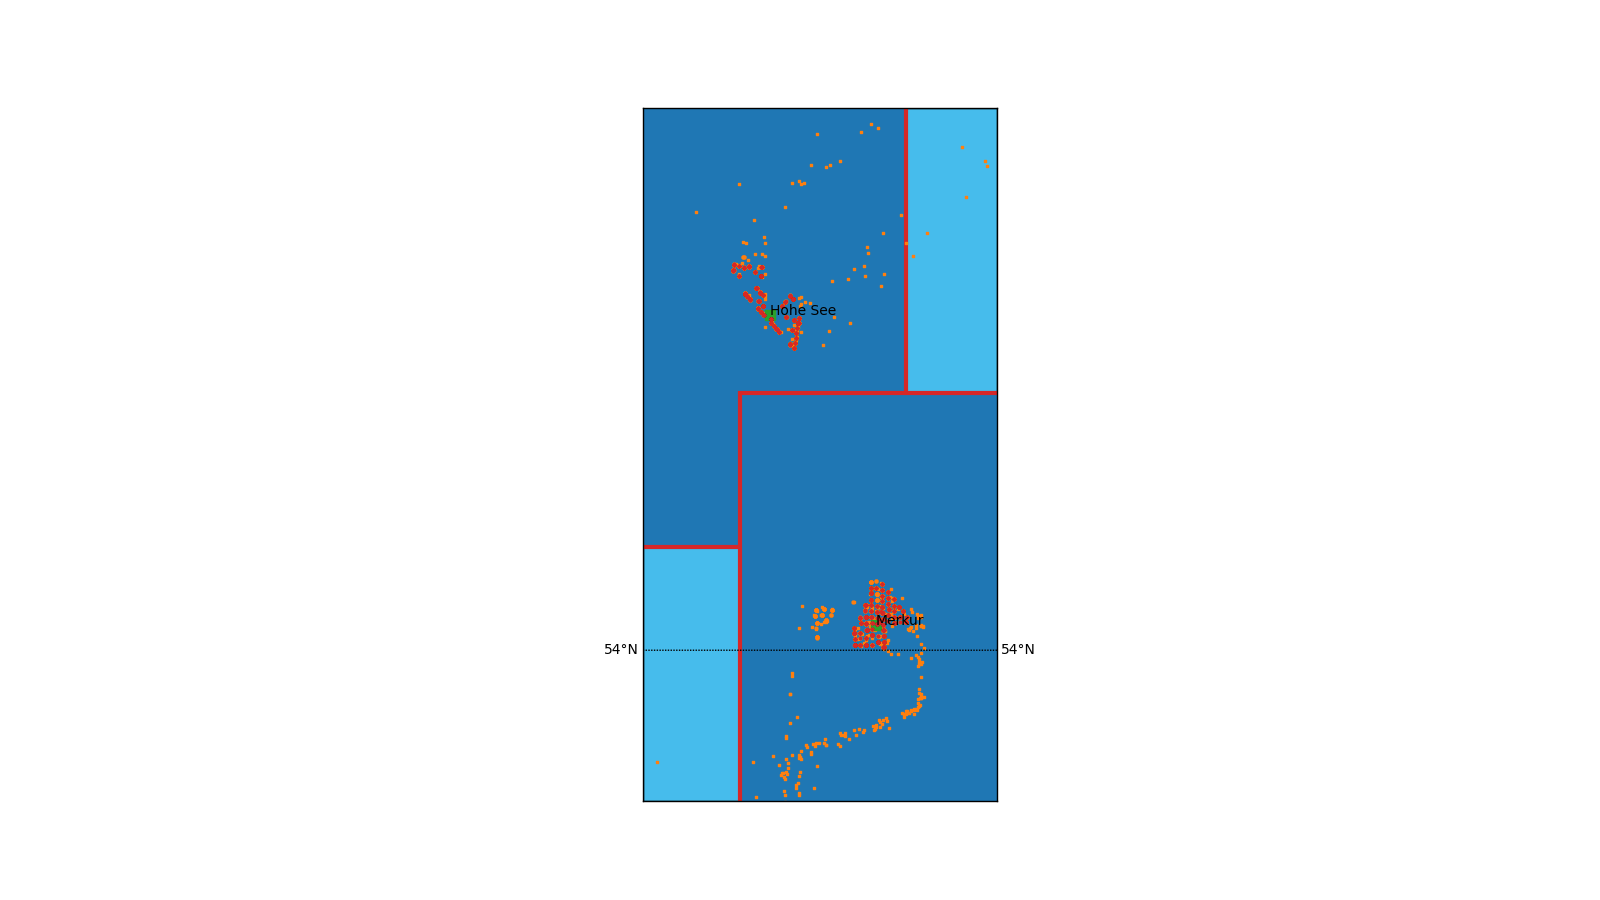

53.803889999999996 54.69774 6.036168 6.8187050000000005
processing: 245924000_mpi-adventure


<IPython.core.display.Javascript object>


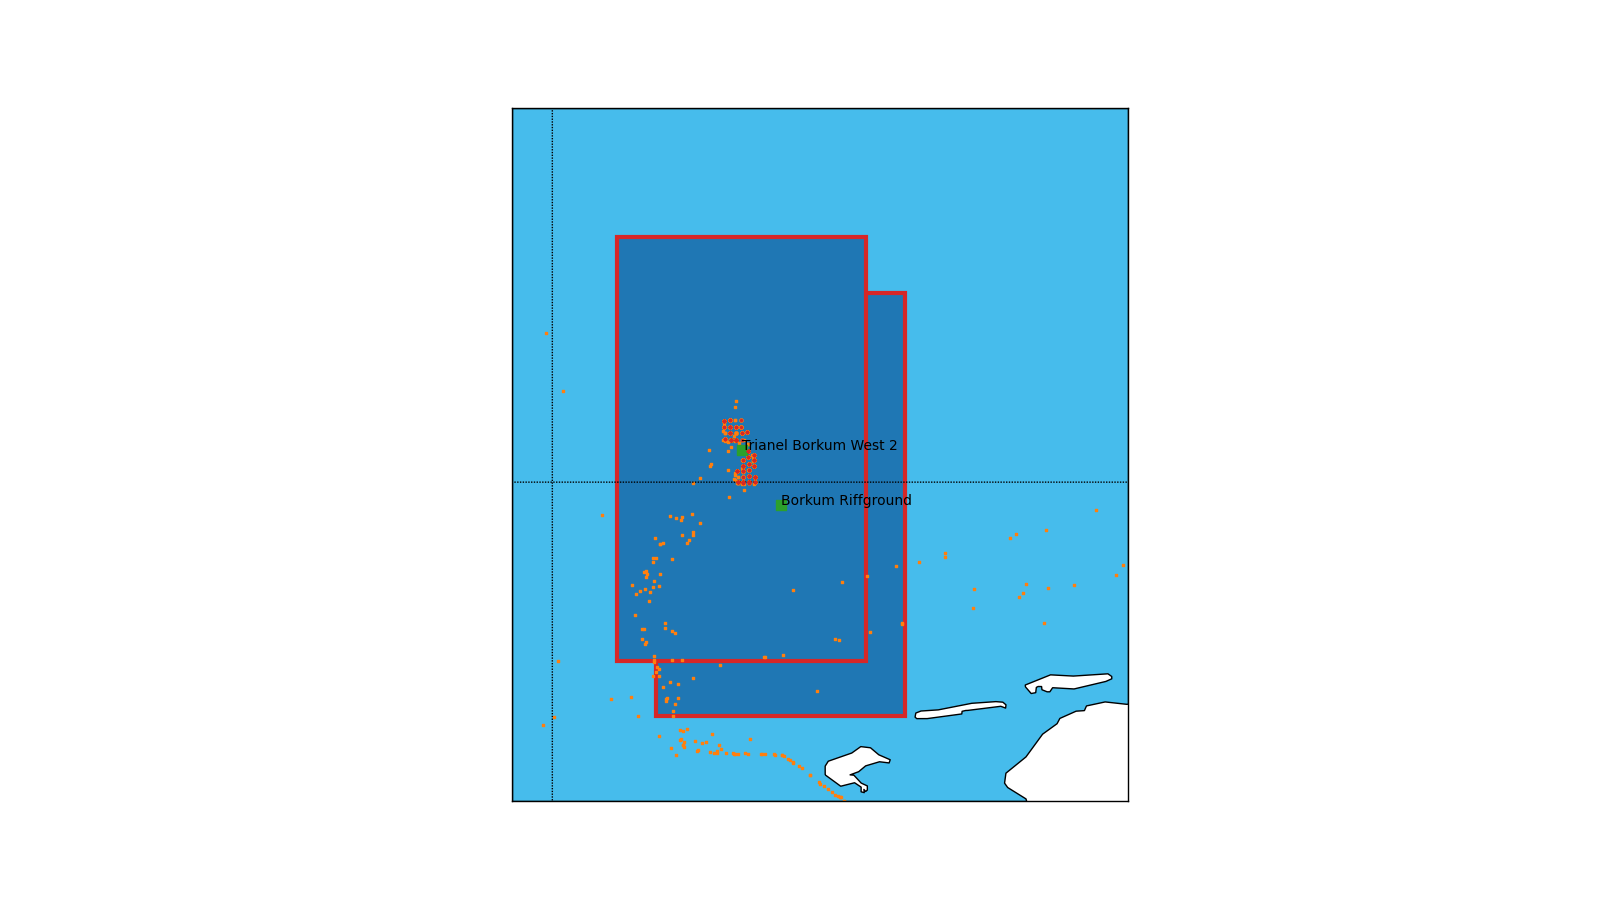

53.443169999999995 55.03419 0.05116670000000001 14.275929999999999
processing: 219019002_sea-challenger


<IPython.core.display.Javascript object>


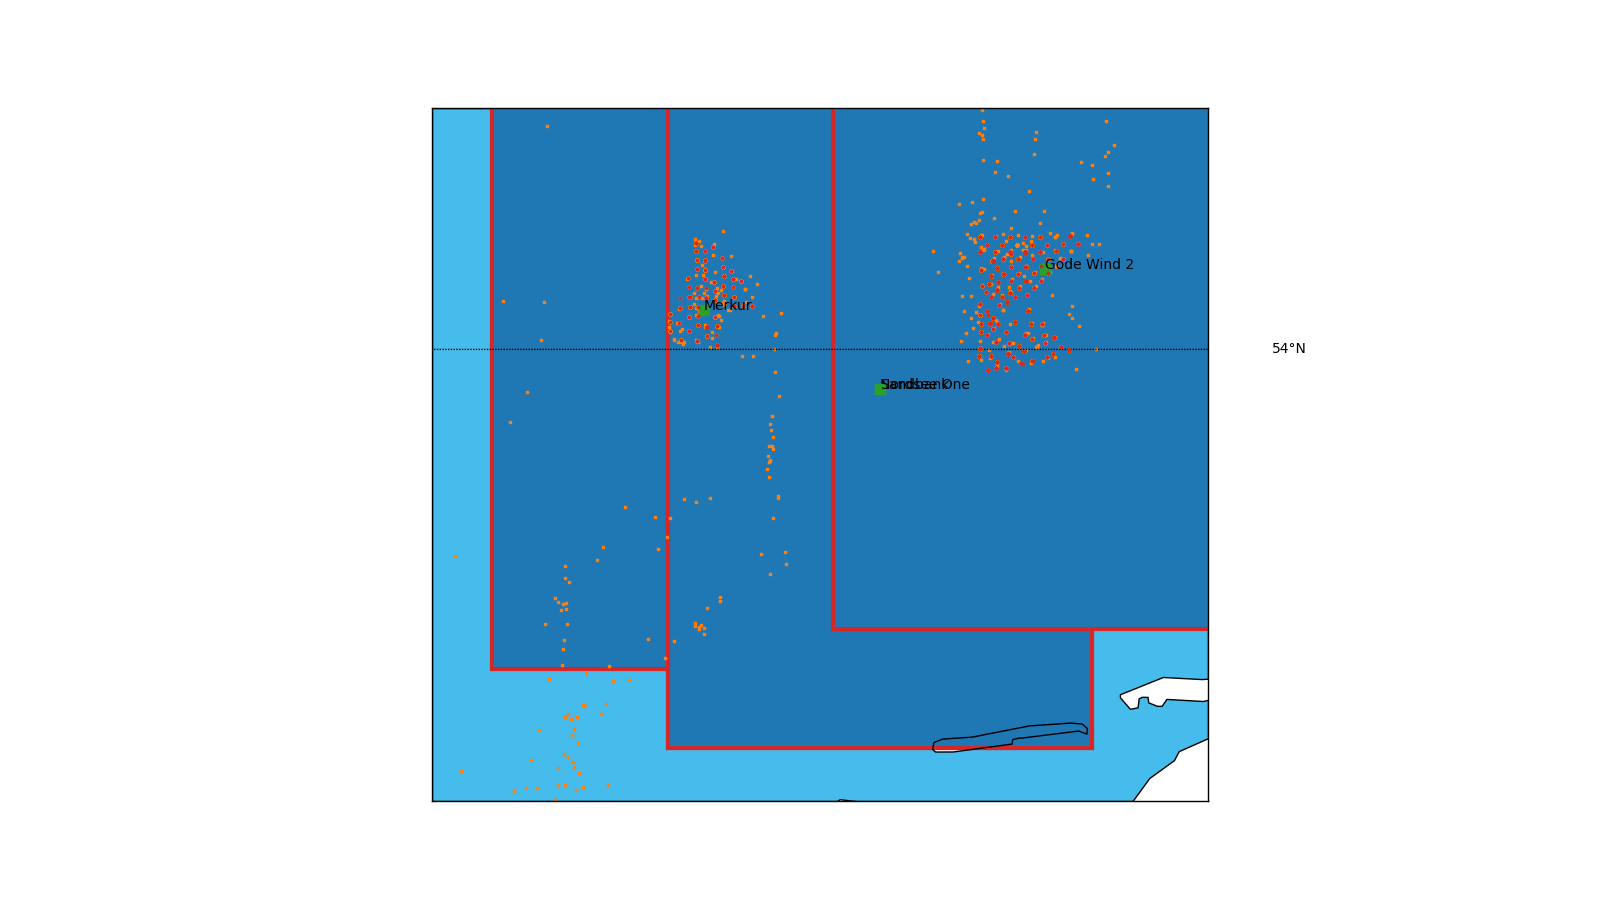

51.38325 54.29383 -0.11117 7.279834
processing: 253609000_taillevent


<IPython.core.display.Javascript object>


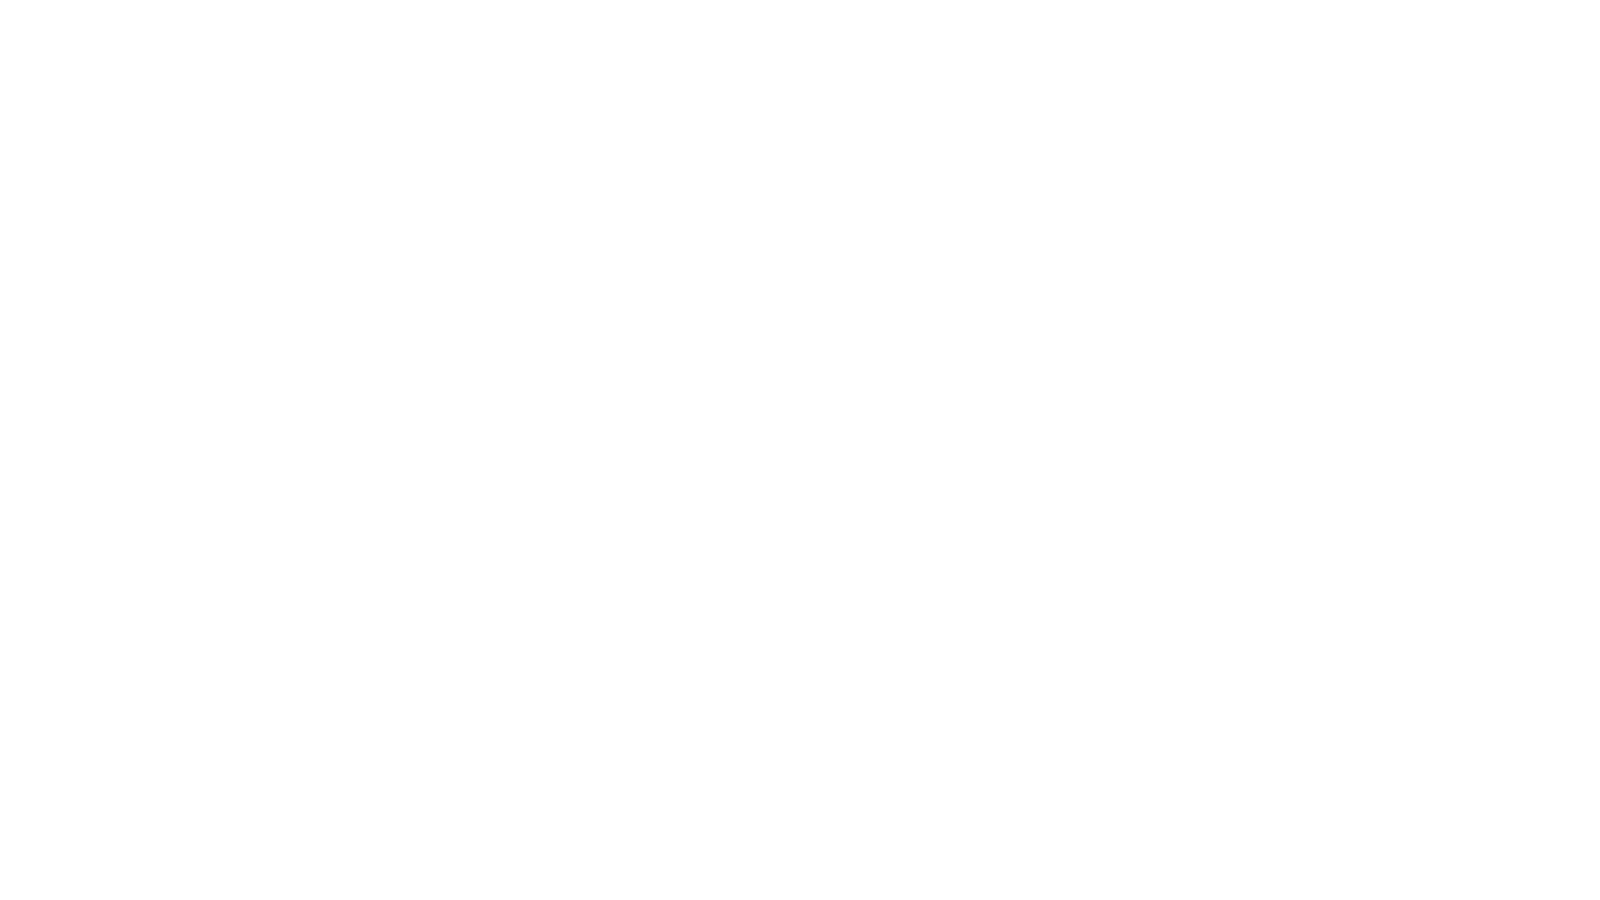

0 0 0 0
failed to plot vessel wind farms: float division by zero
processing: 253366000_vole-au-vent


<IPython.core.display.Javascript object>


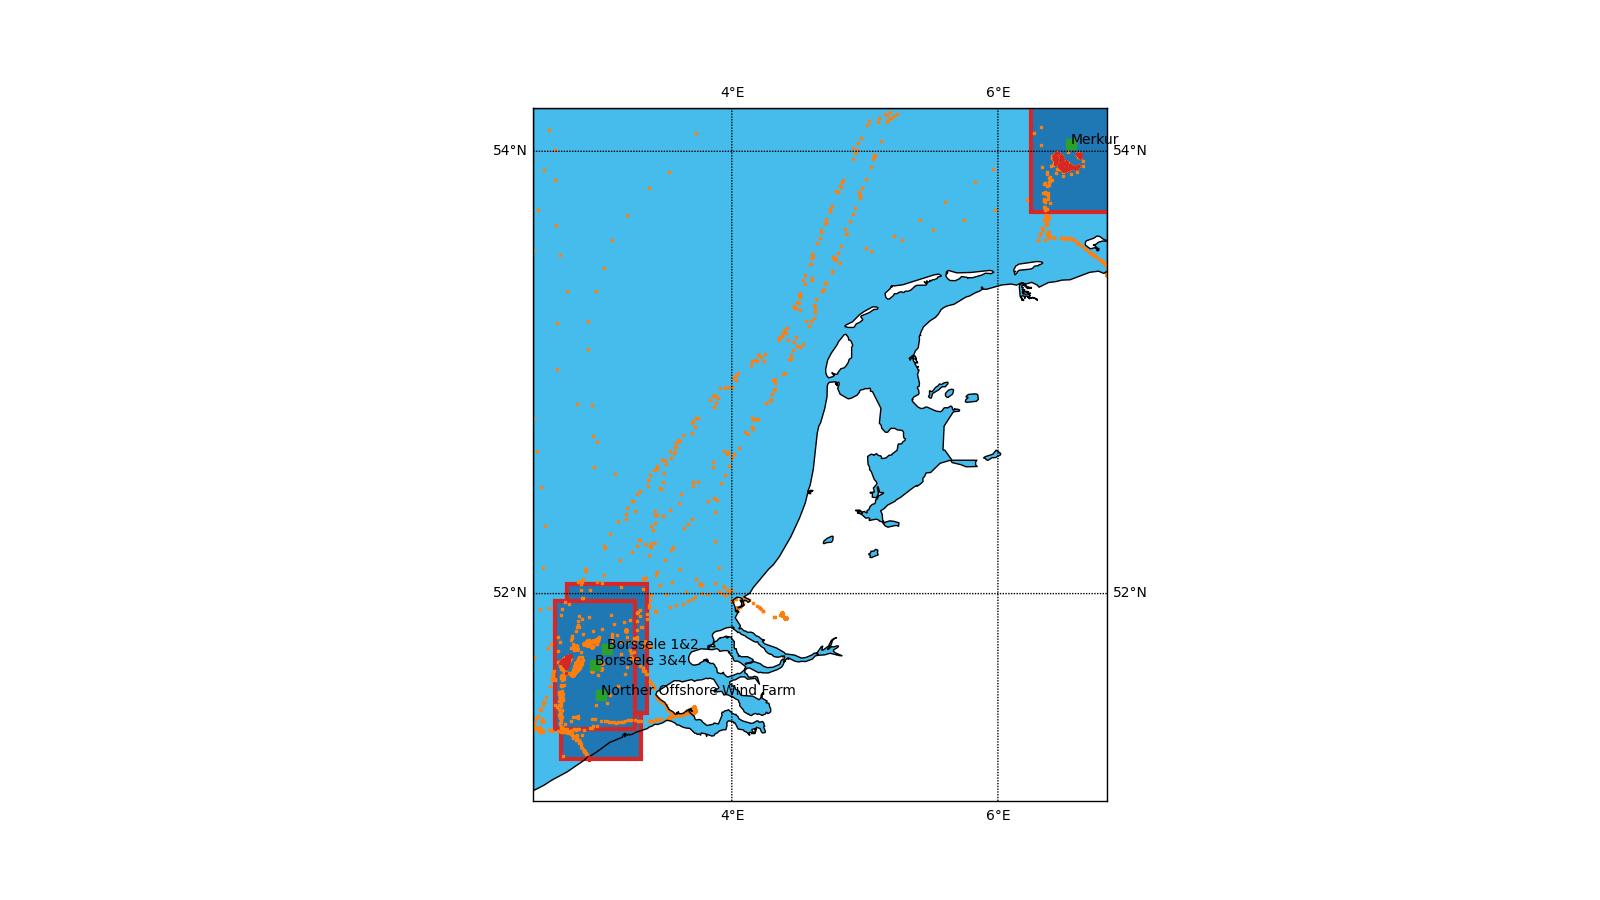

51.02997 54.190900000000006 2.507217 6.818767
processing: 246777000_mpi-resolution


<IPython.core.display.Javascript object>


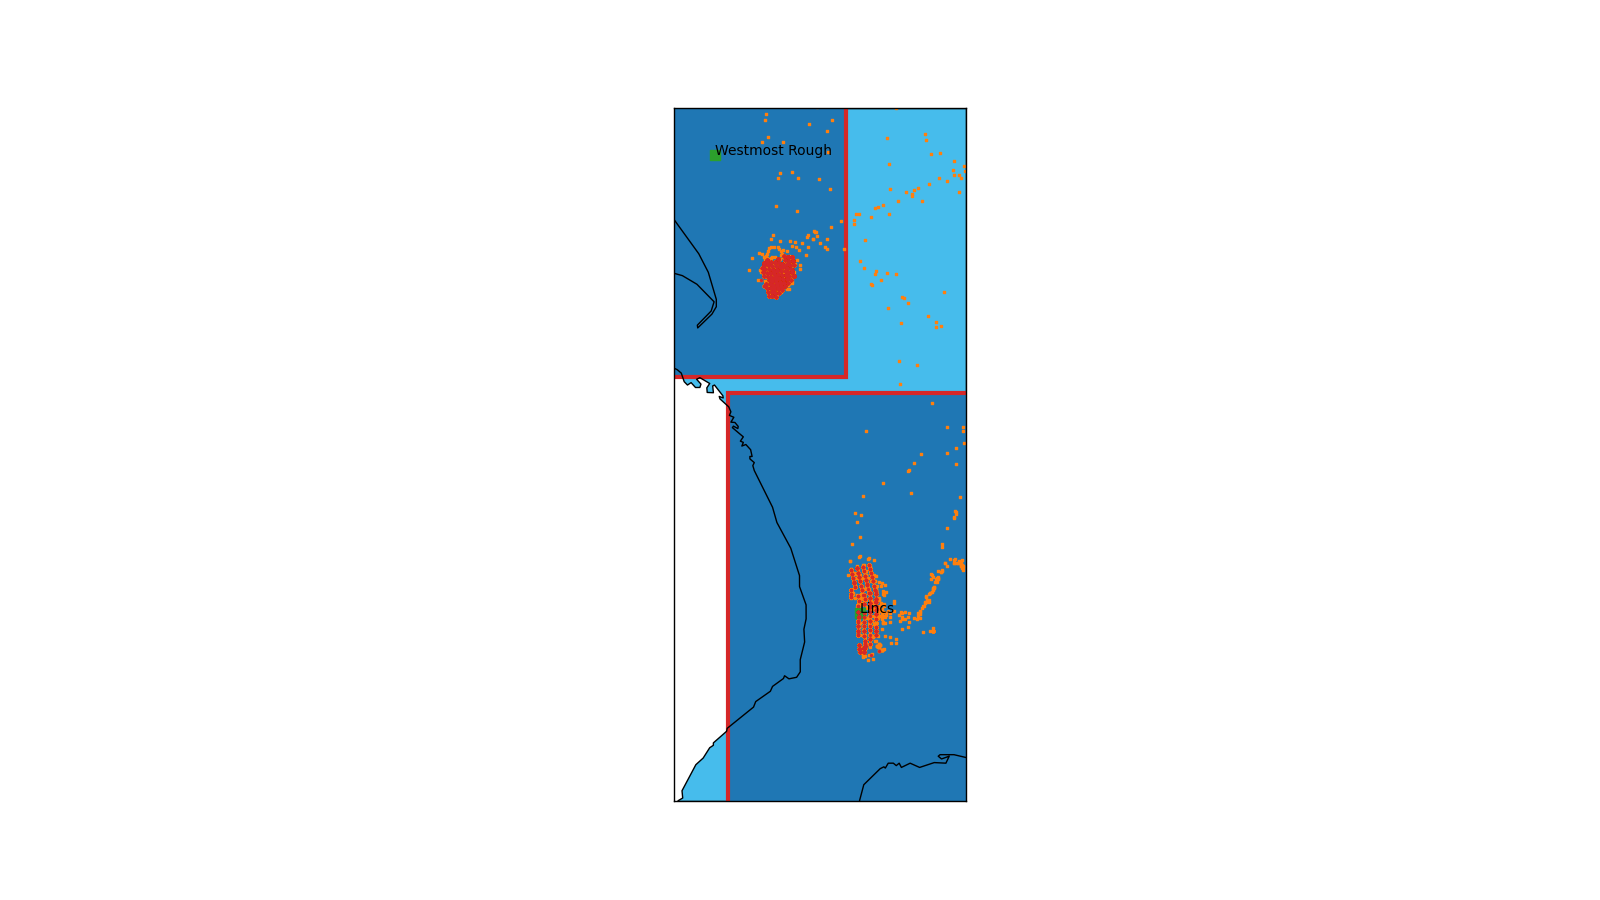

52.92505 53.86834 0.05481999999999998 0.7235682999999999
processing: 245179000_aeolus


<IPython.core.display.Javascript object>


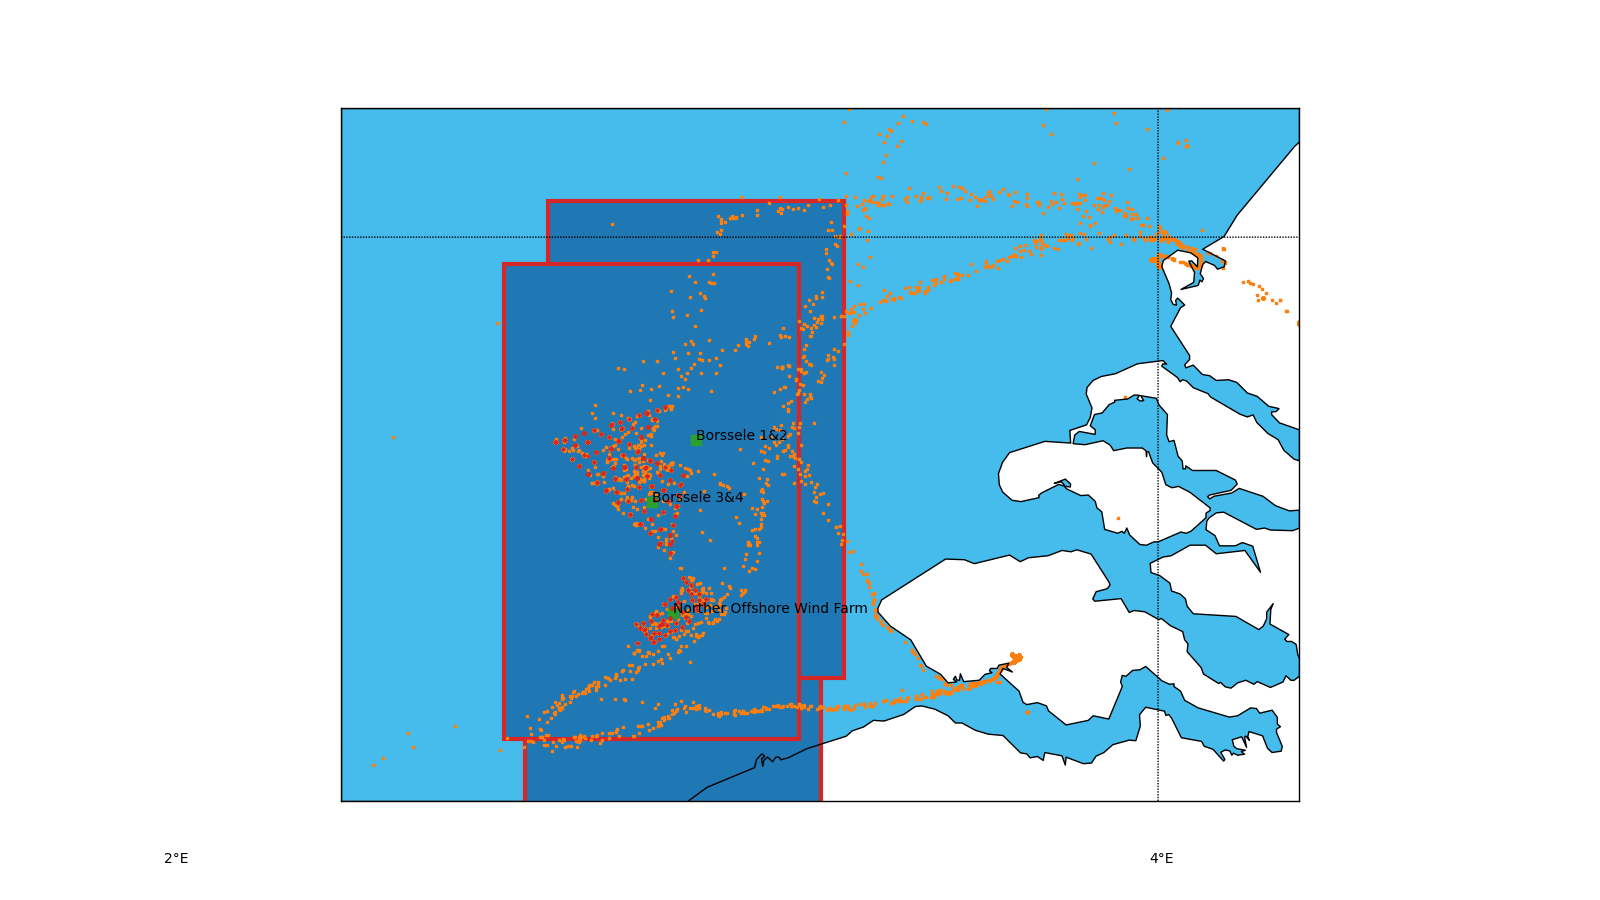

51.28883 54.353 -4.013167 6.3098920000000005
processing: 229080000_bold-tern


<IPython.core.display.Javascript object>


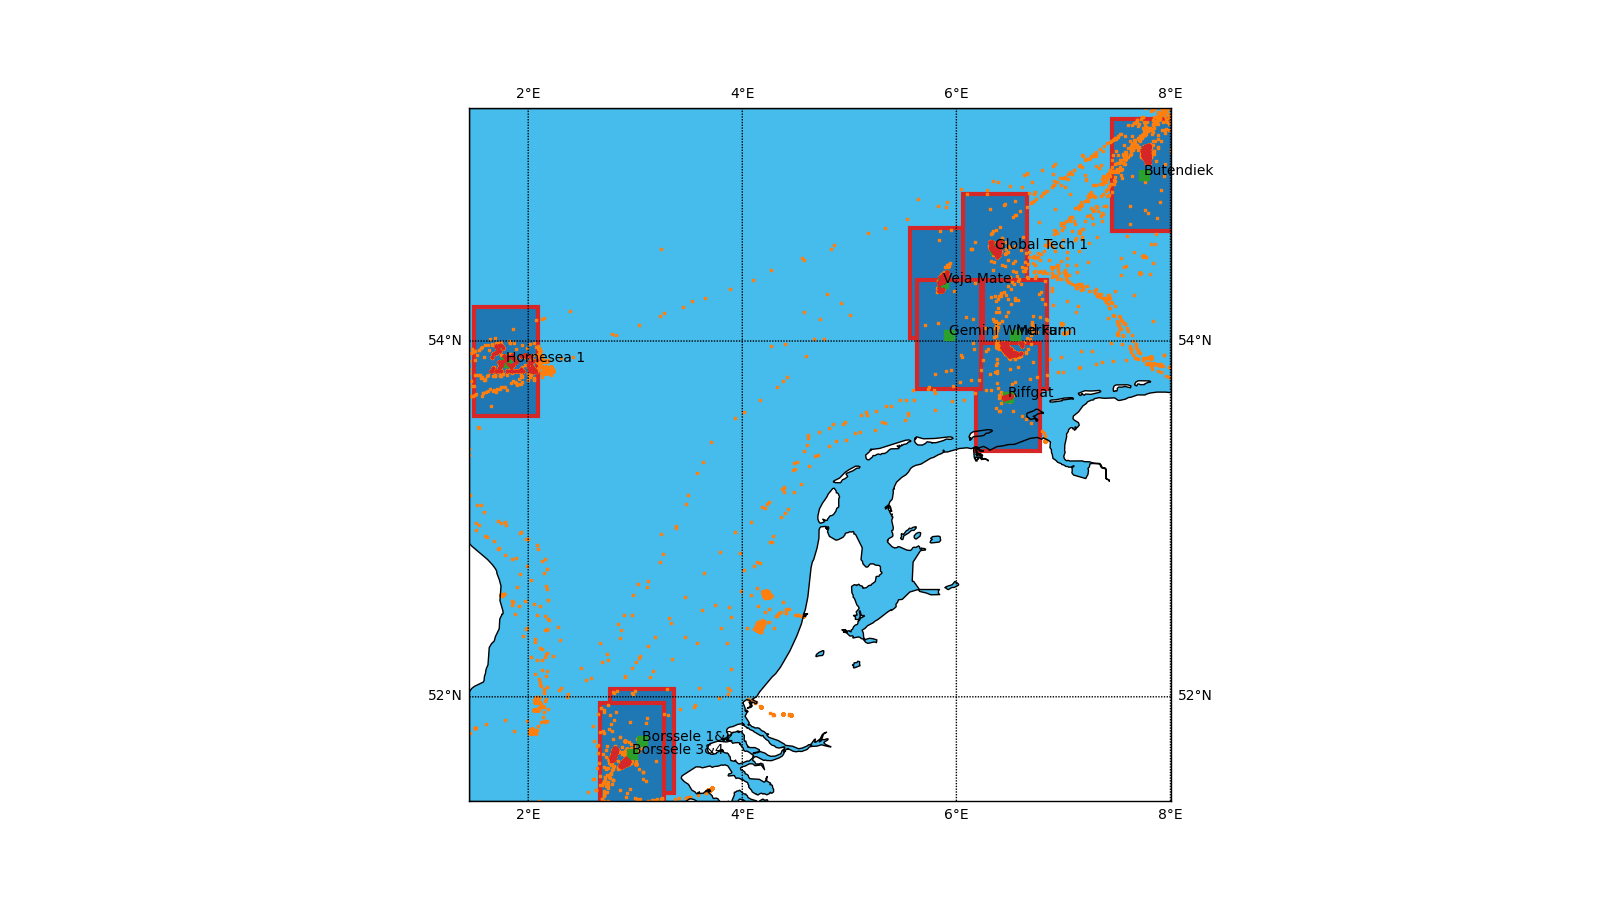

51.39667 55.260000000000005 1.450167 8.001667
processing: 215644000_blue-tern


<IPython.core.display.Javascript object>


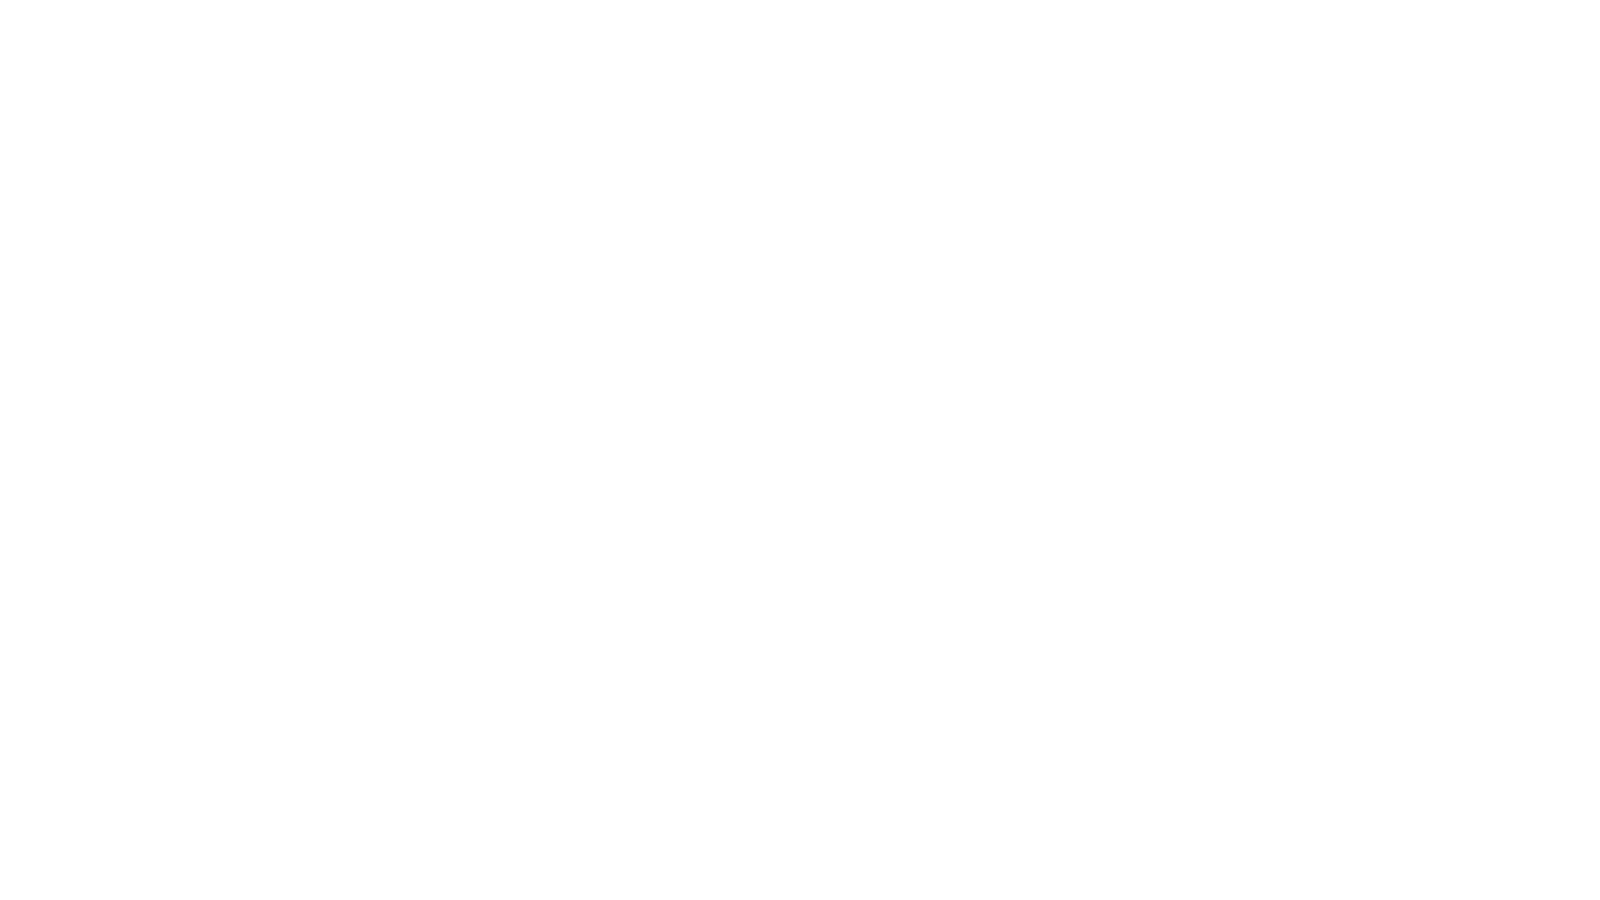

0 0 0 0
failed to plot vessel wind farms: float division by zero
processing: 229044000_brave-tern


<IPython.core.display.Javascript object>


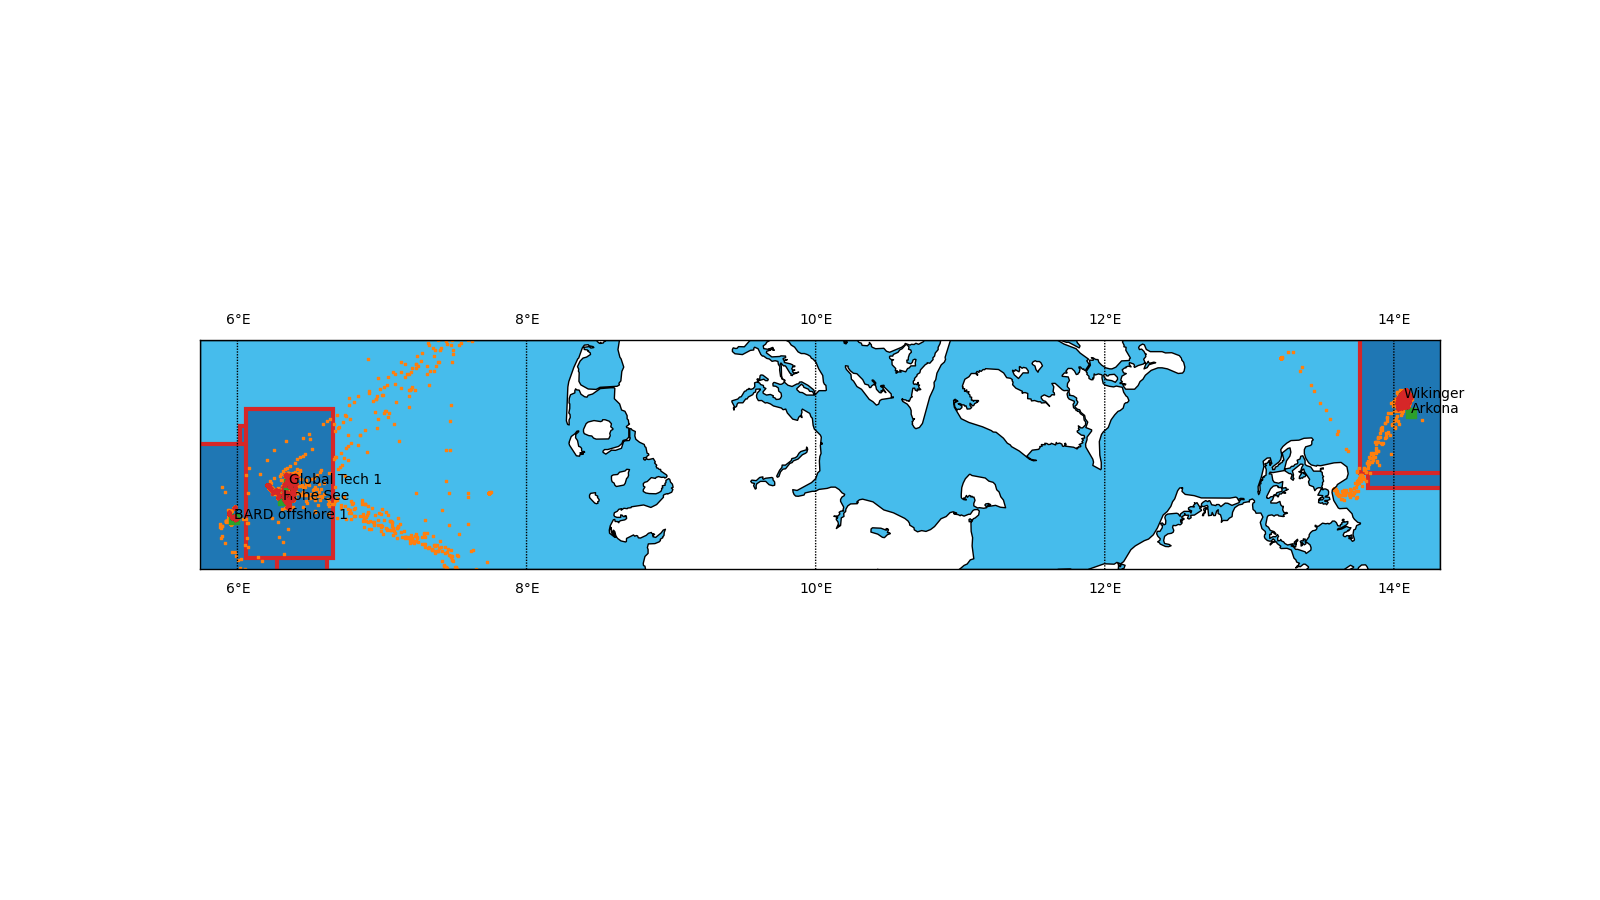

54.155339999999995 55.07547 5.741 14.319249999999998
processing: 218657000_vole-au-vent


<IPython.core.display.Javascript object>


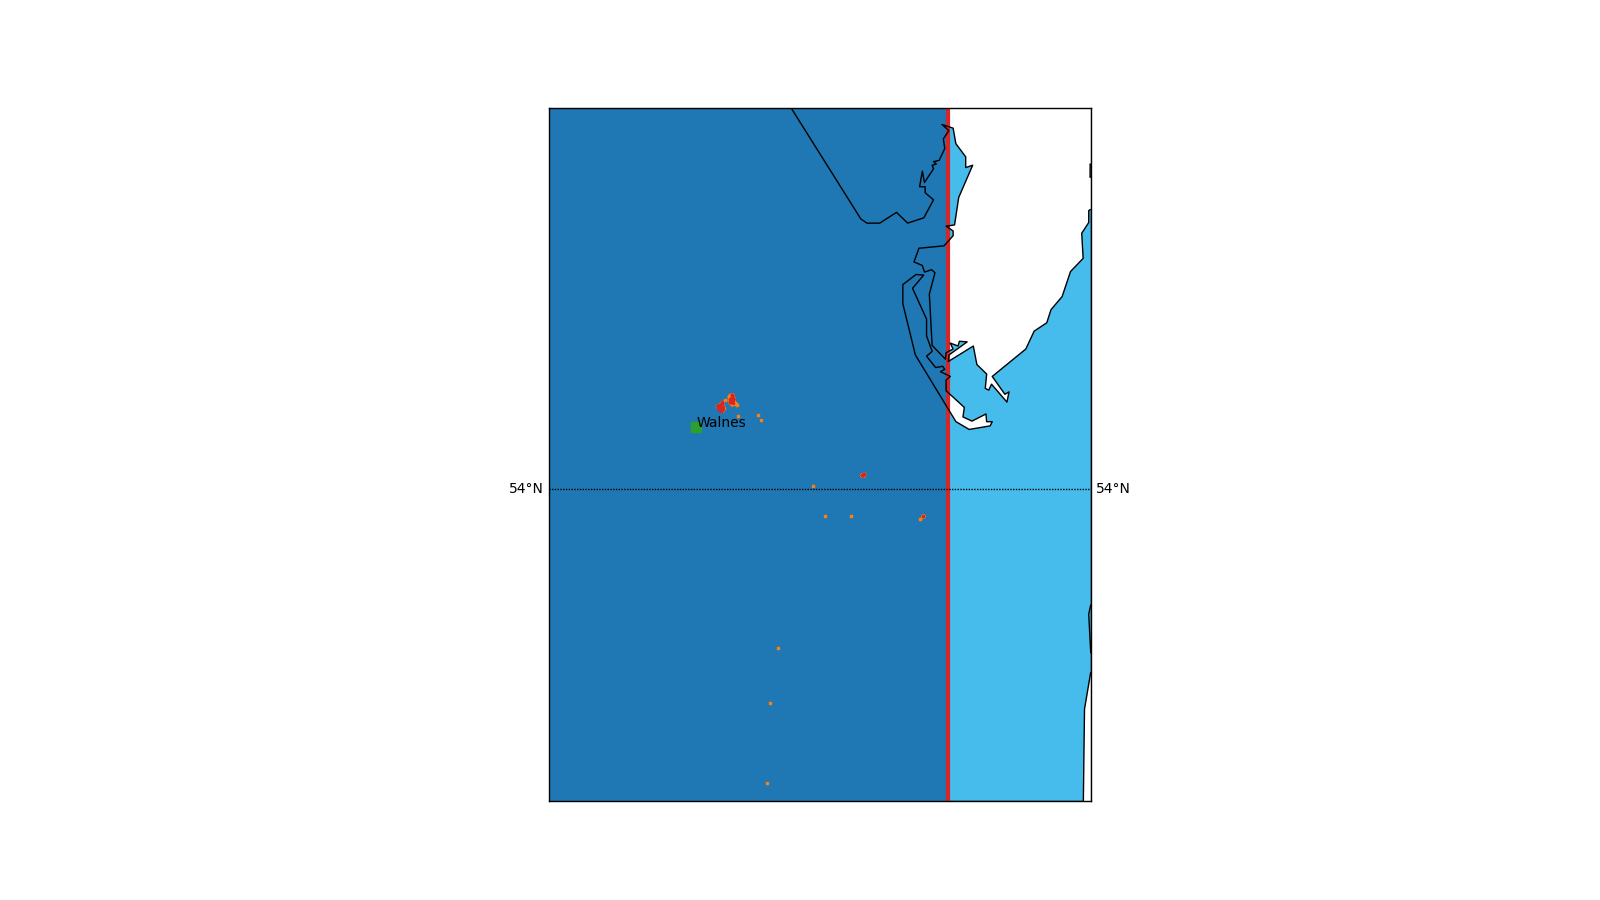

53.781099999999995 54.2665 -3.697433 -3.051733
processing: 218389000_thor


<IPython.core.display.Javascript object>


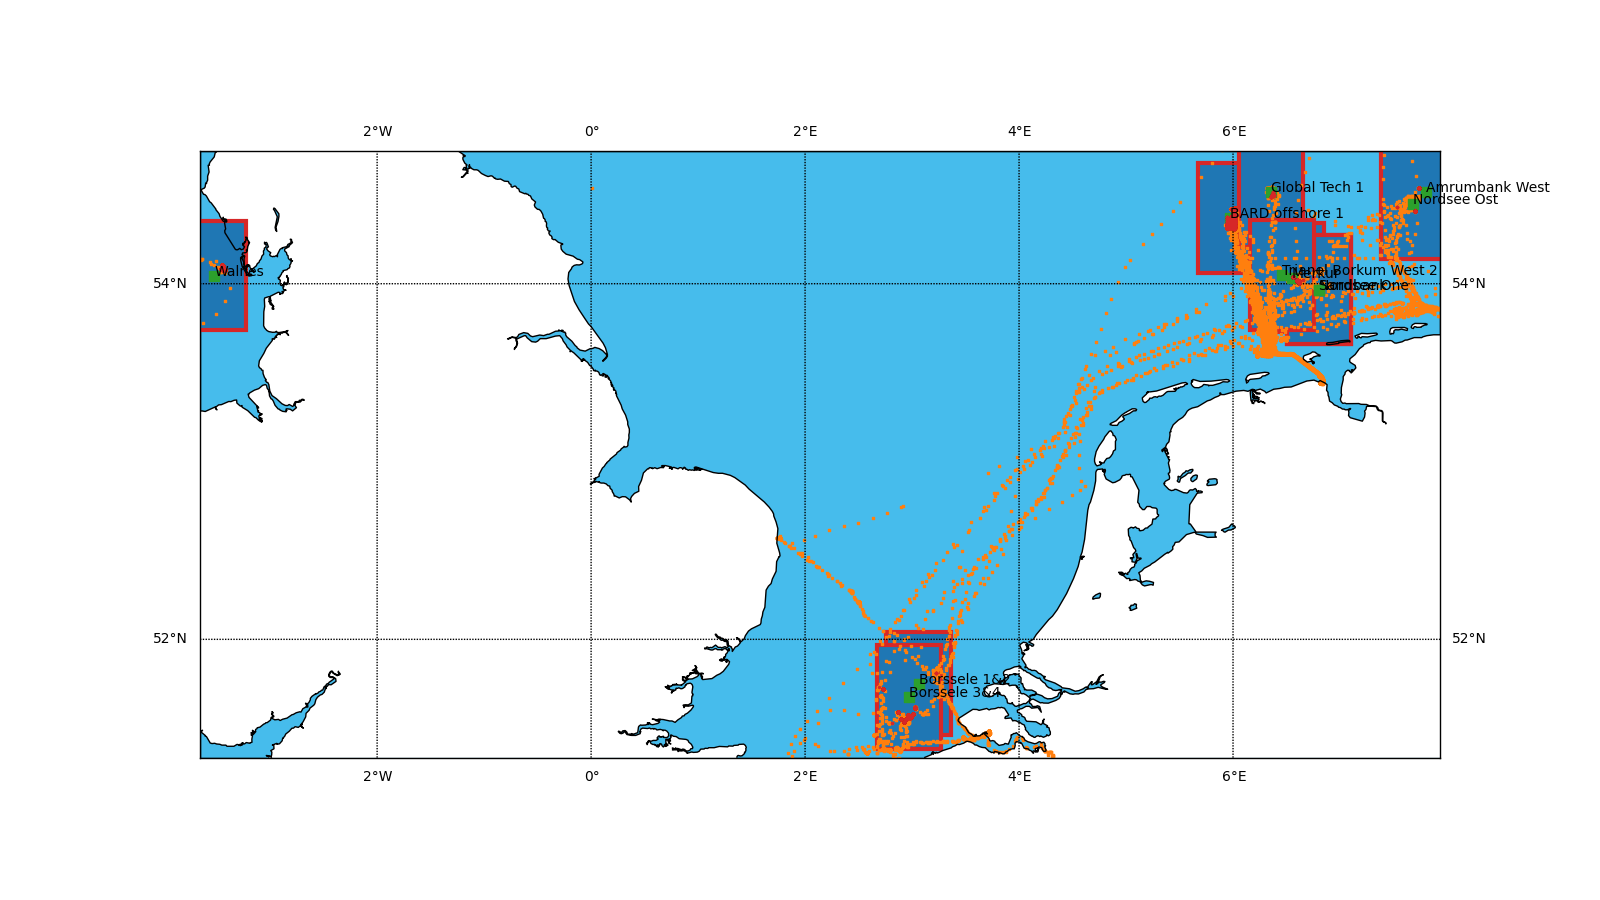

51.31388 54.72097 -3.6555820000000003 7.9345170000000005


In [223]:
# plot_vessel_farms(vessels['245924000_mpi-adventure'], vessel_farms['245924000_mpi-adventure'], wind_farms)
for vessel in vessels.keys():
    print(f'processing: {vessel}')
    try:
        plot_vessel_farms(vessels[vessel], vessel_farms[vessel], wind_farms)
    except Exception as e:
        print(f'failed to plot vessel wind farms: {e}')
        continue

---

# Vessel tracks raw plots

235090598_blue-tern


<IPython.core.display.Javascript object>


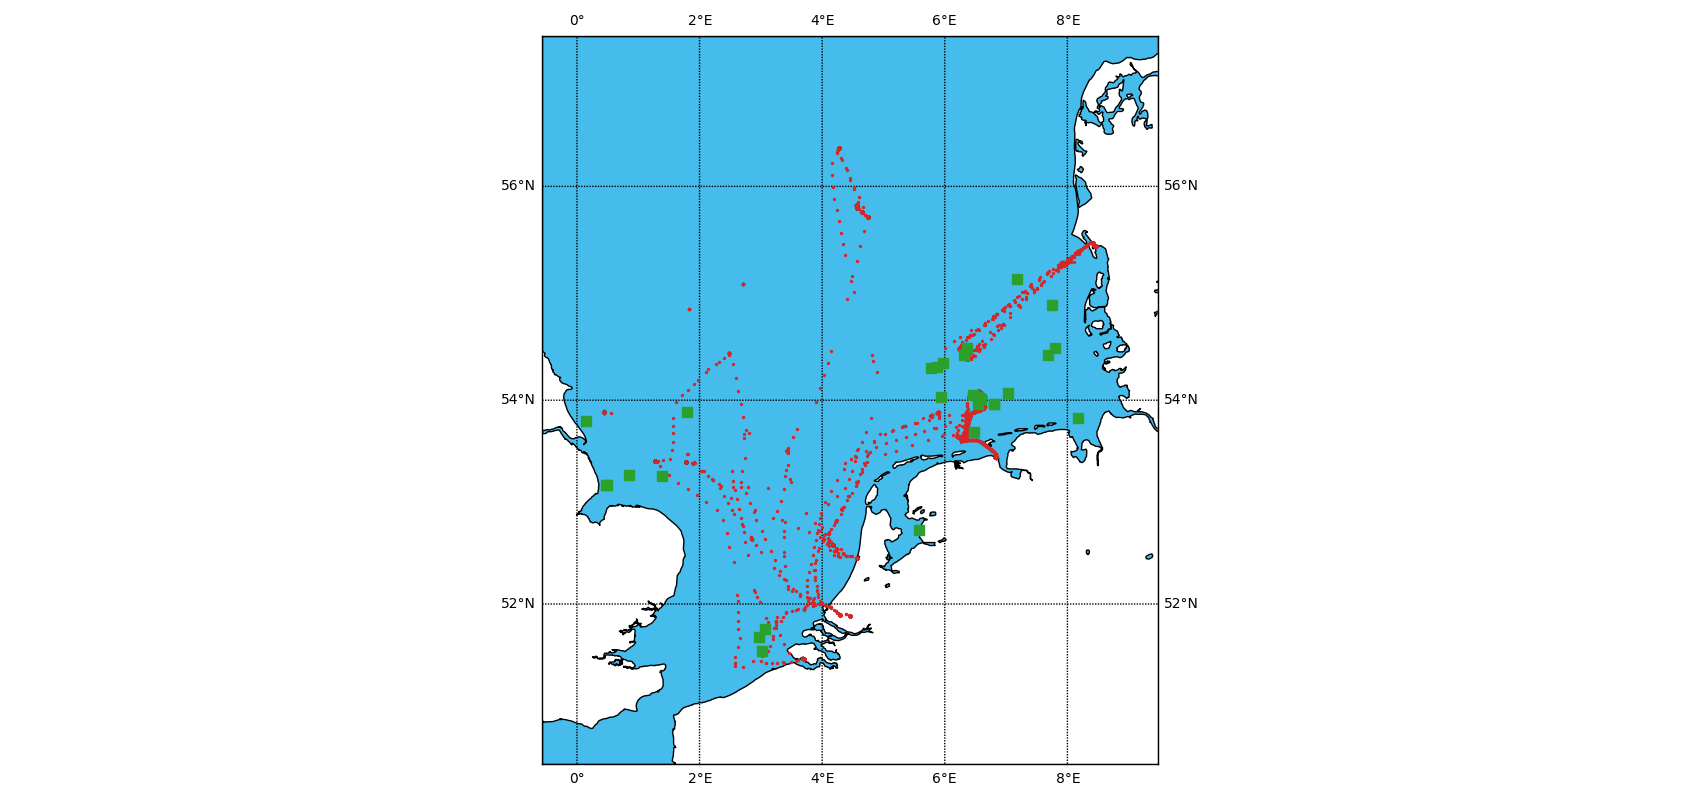

245924000_mpi-adventure


<IPython.core.display.Javascript object>


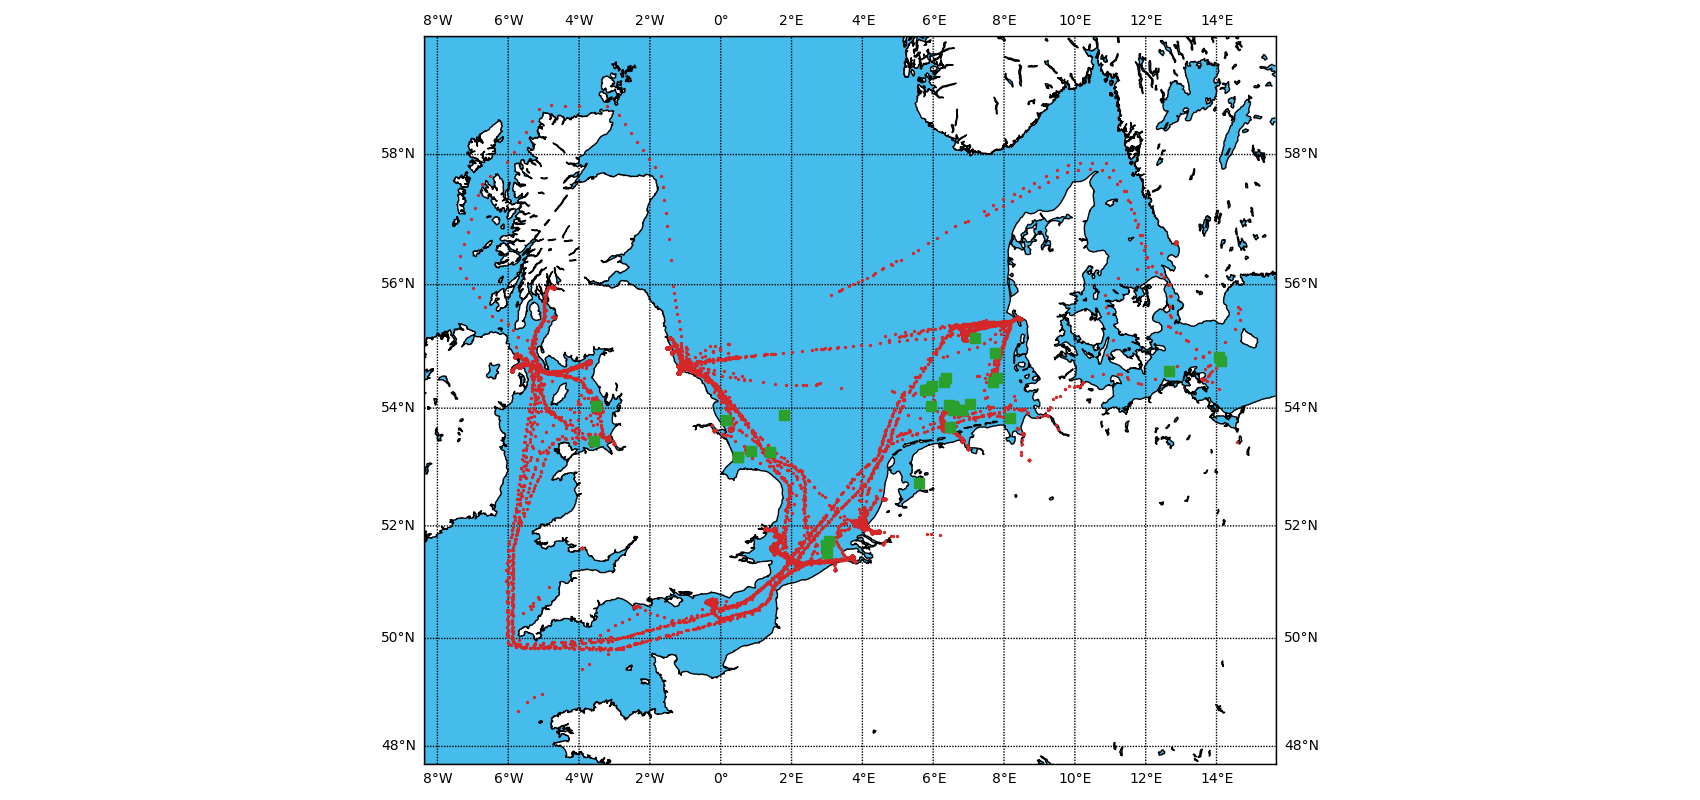

219019002_sea-challenger


<IPython.core.display.Javascript object>


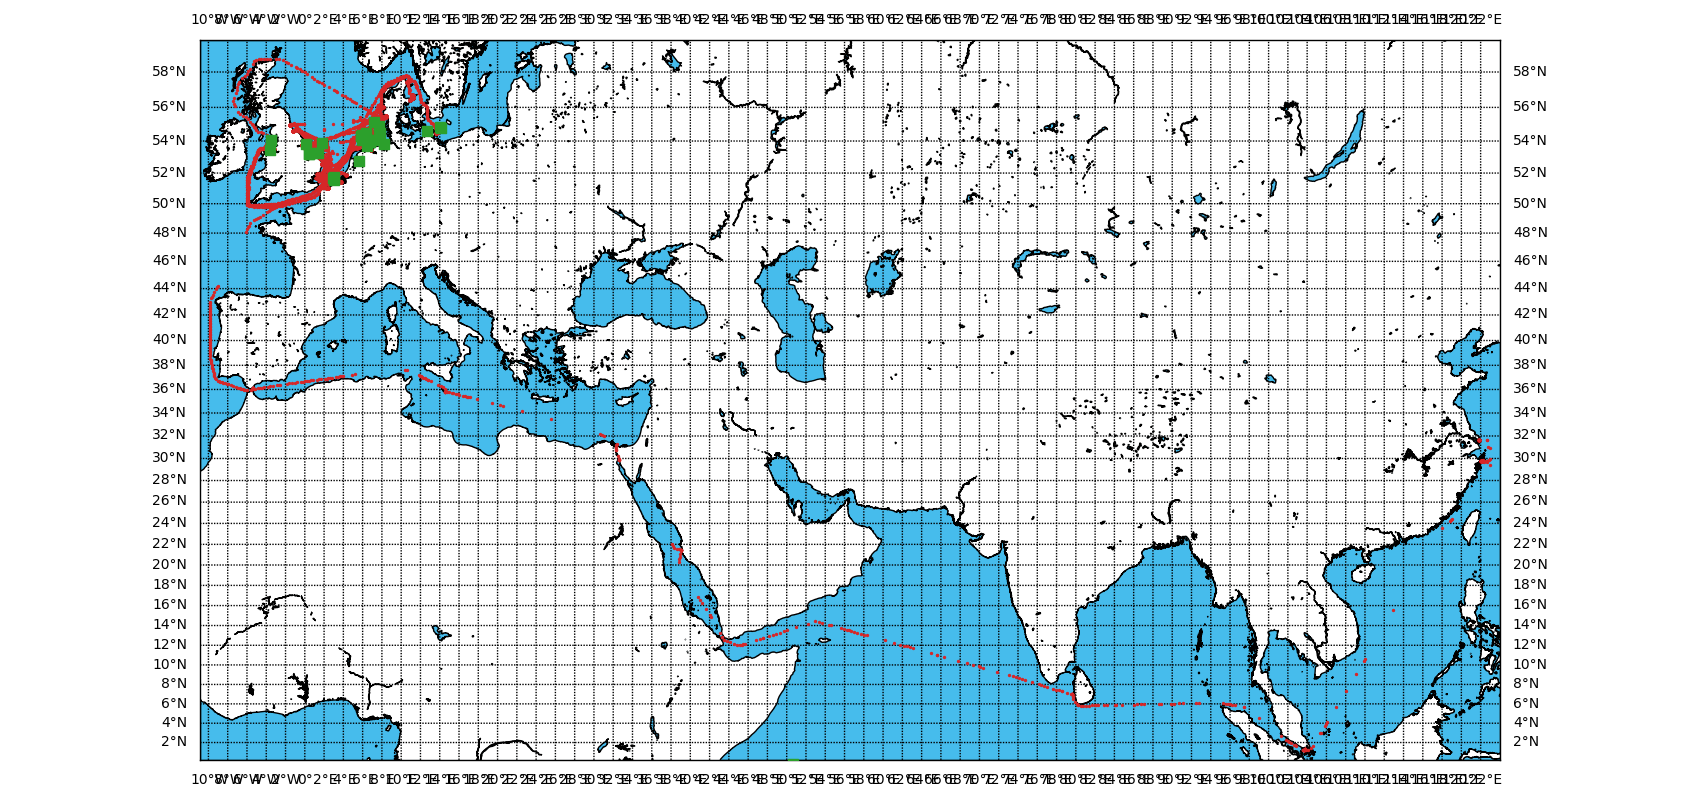

253609000_taillevent


<IPython.core.display.Javascript object>


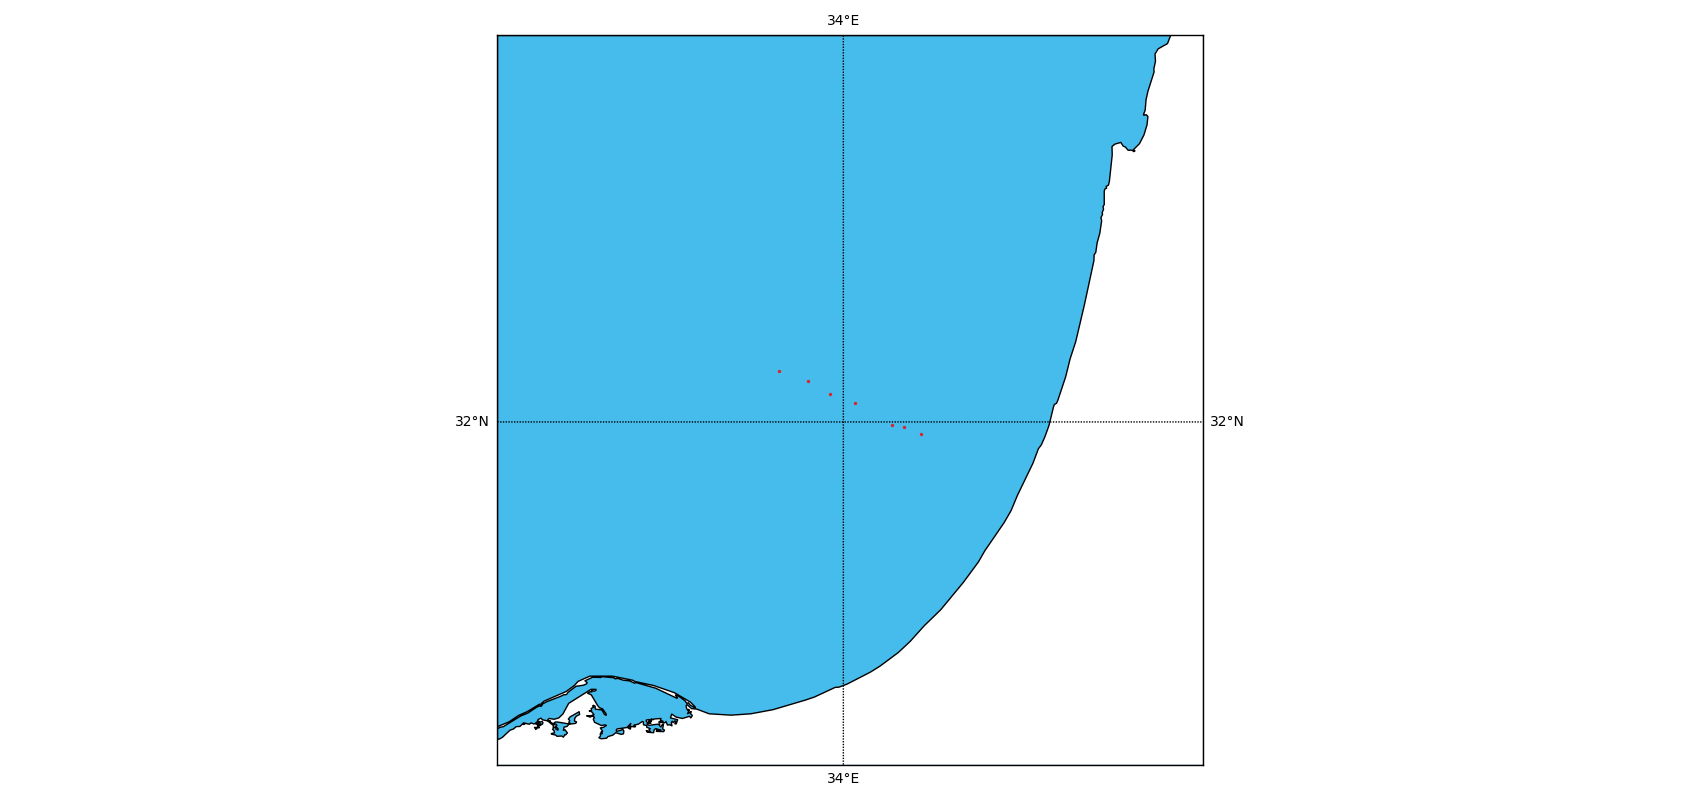

253366000_vole-au-vent


<IPython.core.display.Javascript object>


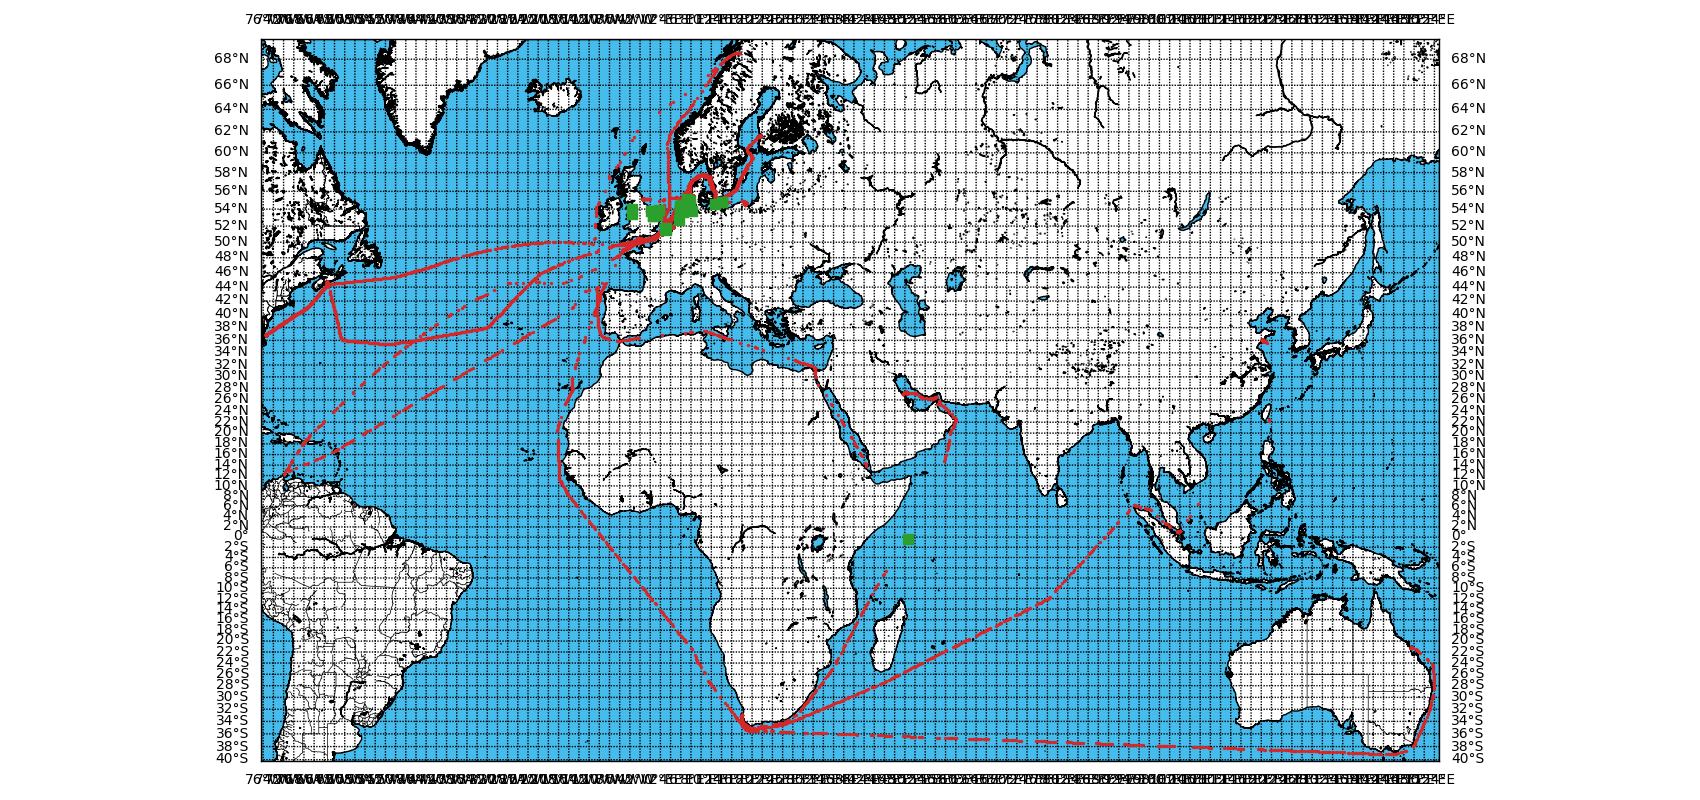

246777000_mpi-resolution


<IPython.core.display.Javascript object>


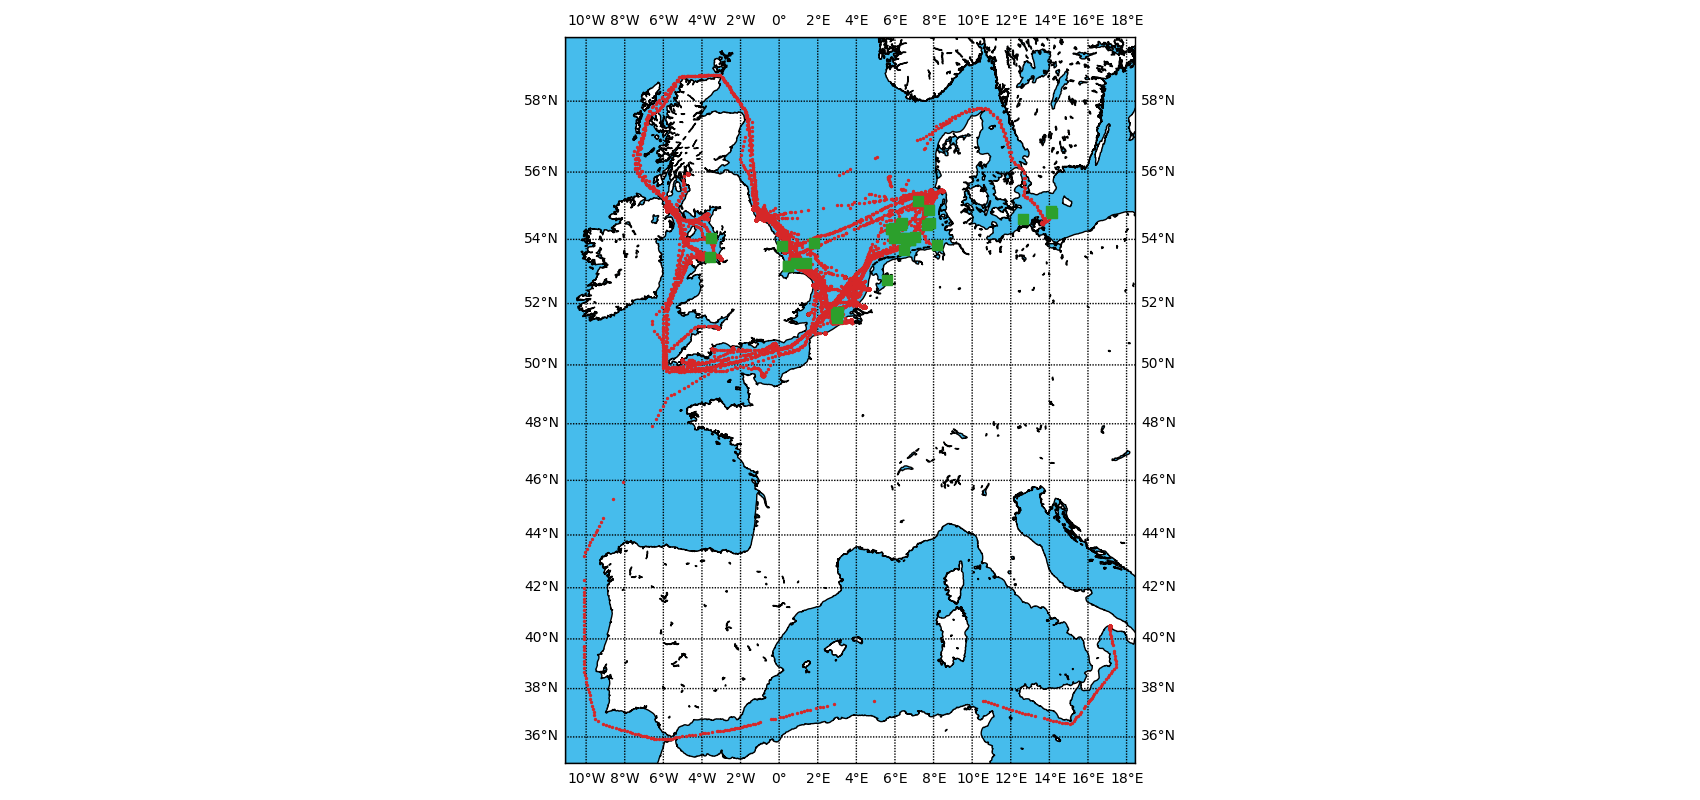

245179000_aeolus


<IPython.core.display.Javascript object>


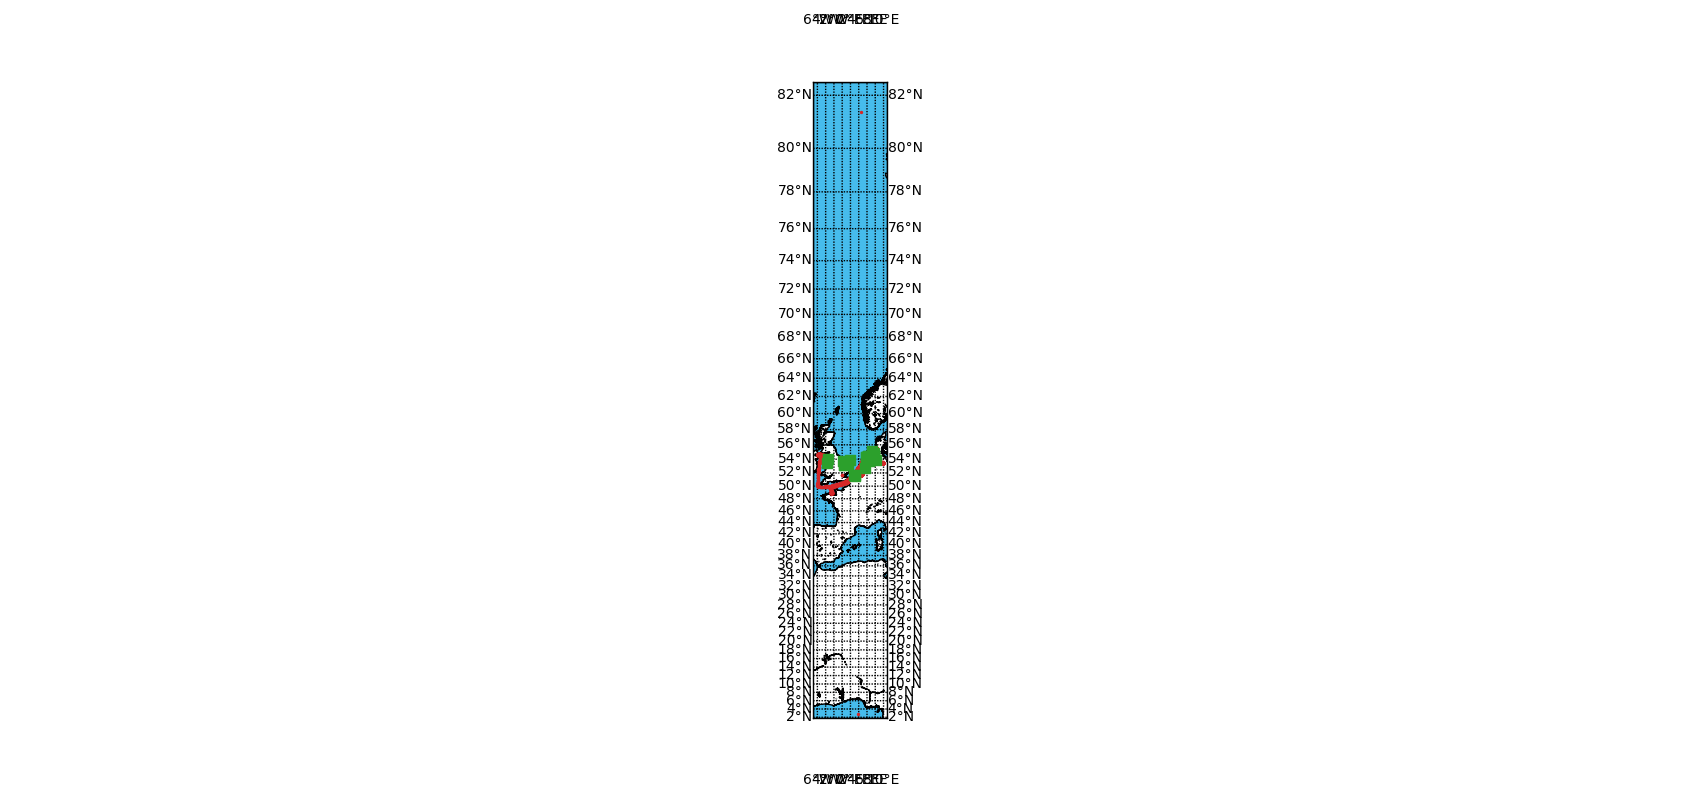

229080000_bold-tern


<IPython.core.display.Javascript object>


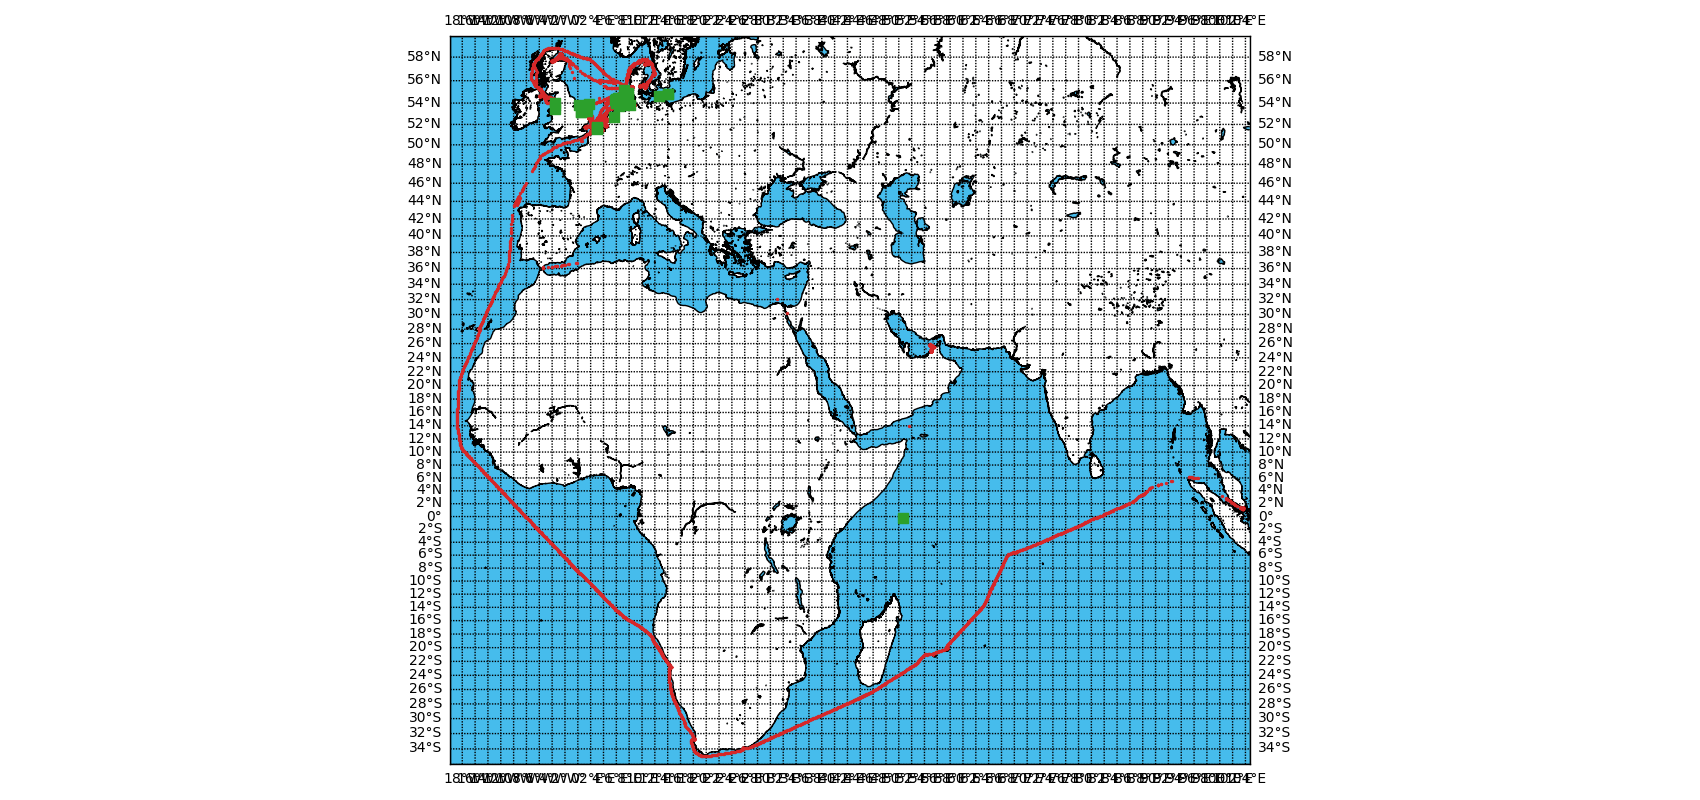

215644000_blue-tern


<IPython.core.display.Javascript object>


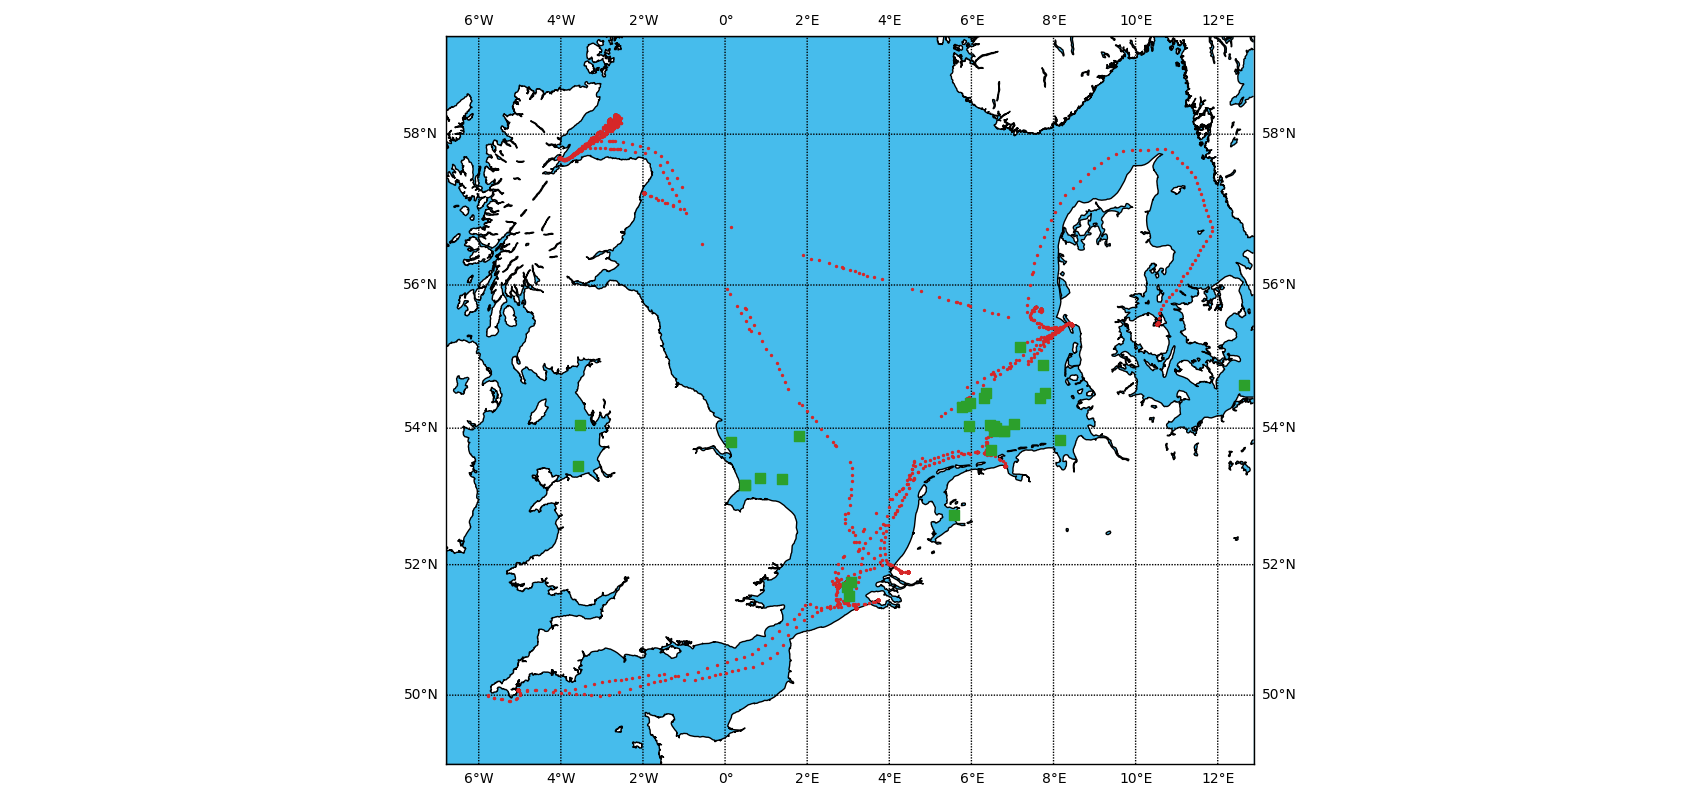

229044000_brave-tern


<IPython.core.display.Javascript object>


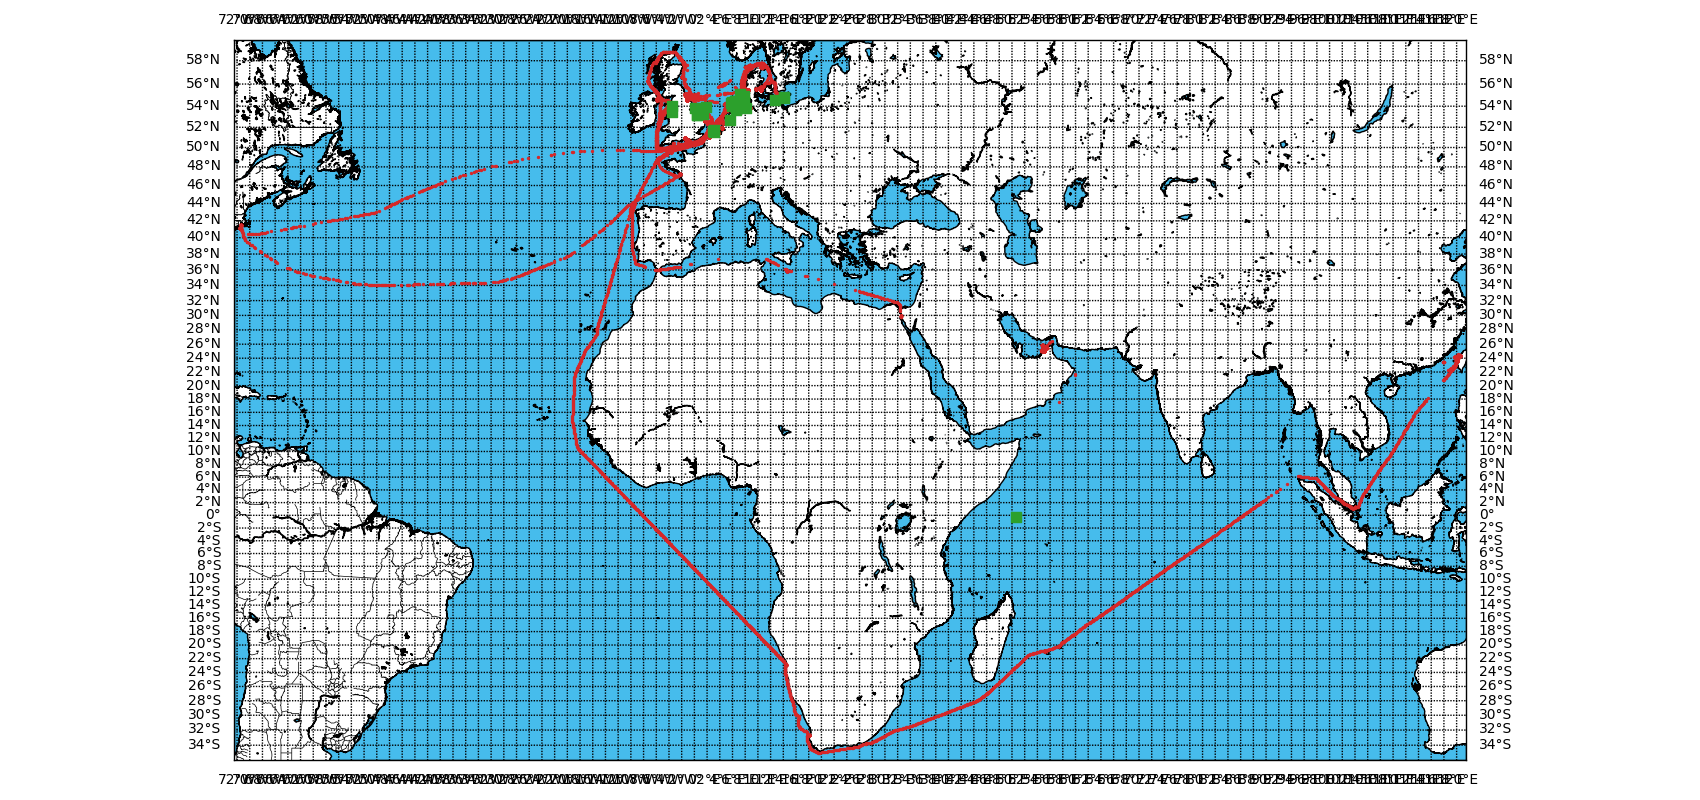

218657000_vole-au-vent


<IPython.core.display.Javascript object>


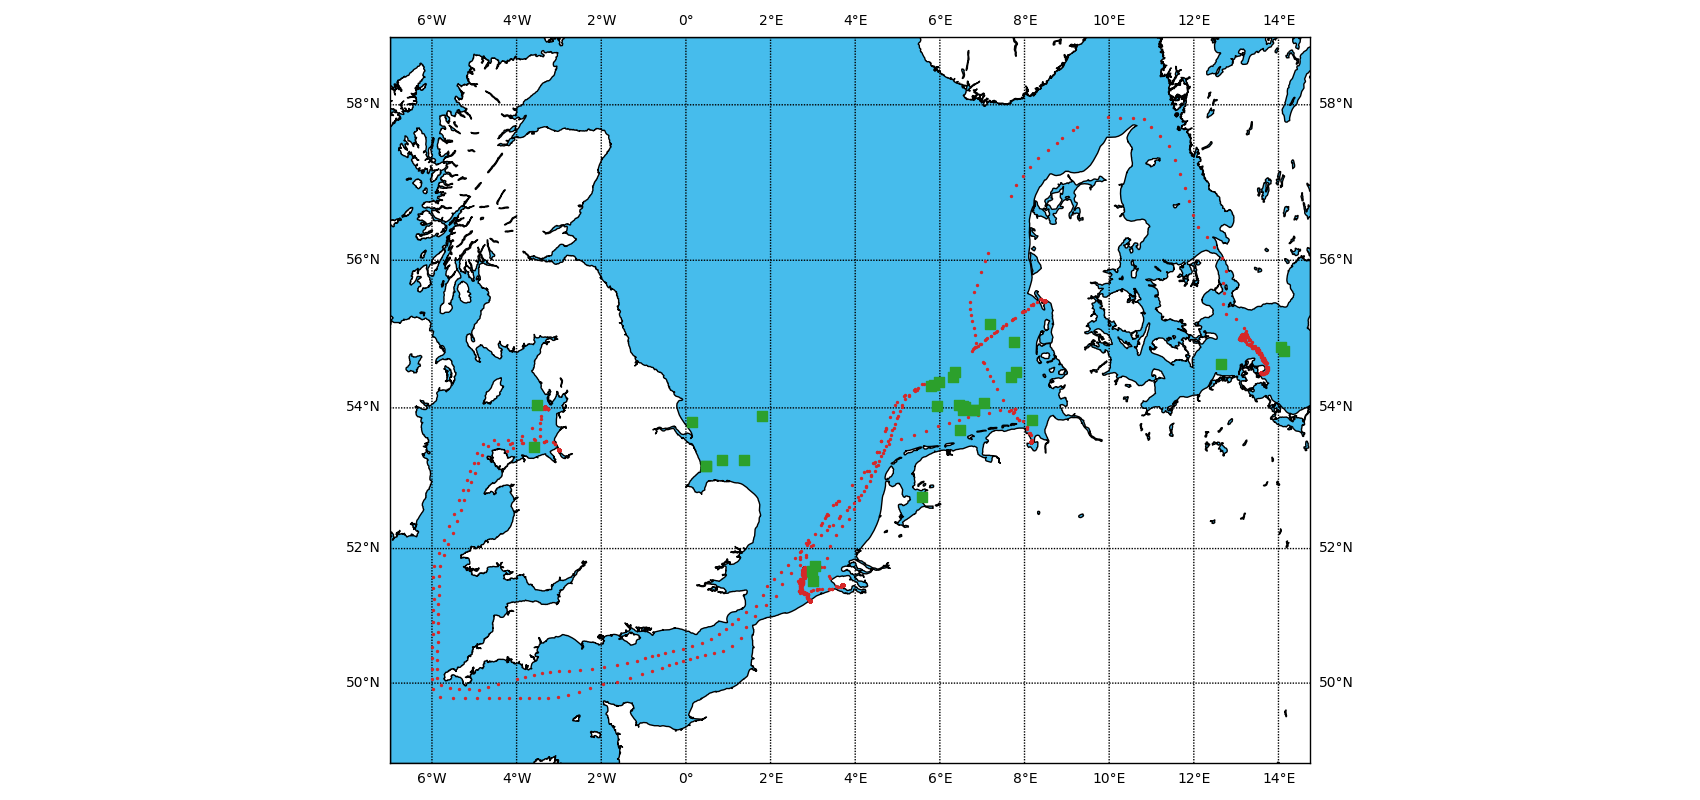

218389000_thor


<IPython.core.display.Javascript object>


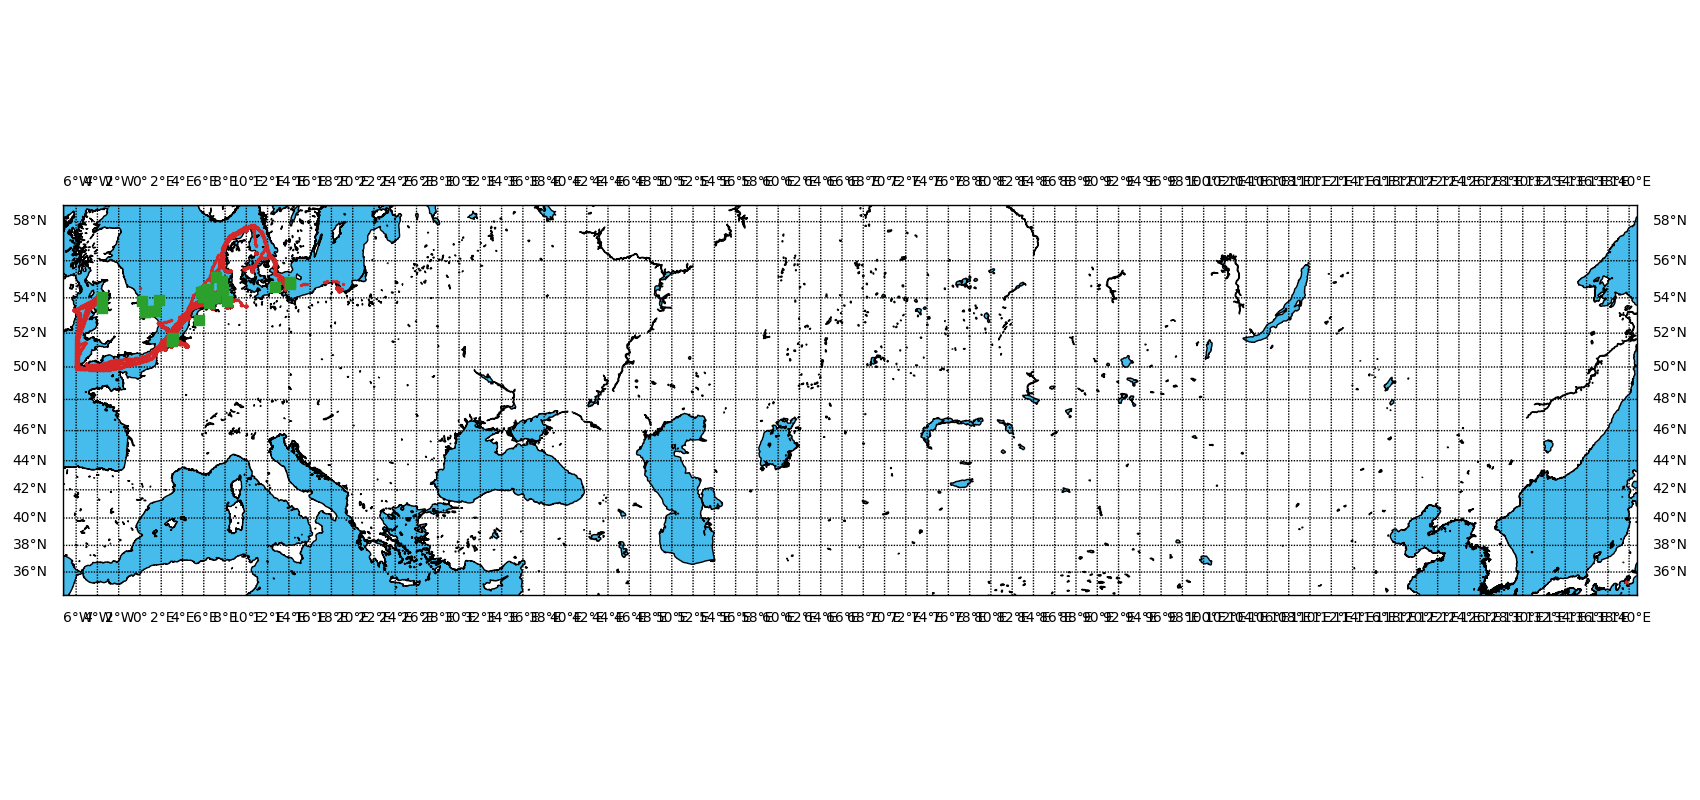

In [110]:
for vessel, data in vessels.items():
    print(vessel)
    try:
        plot_track(data, vessel, wind_farms=wind_farms, figsize=(17,8))
    except Exception as e:
        print(f'failed to plot data for vessel {vessel}: {e}')